---
---

<div align='center' style='font-size: 30px;'>
SETUP
</div>

---

# 1 - Modules

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely import wkt

from os.path import exists
from os import makedirs

from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

import unicodedata

from matplotlib.ticker import FuncFormatter

import seaborn as sns


from sklearn.metrics.pairwise import cosine_similarity

from scipy.optimize import curve_fit


# 2 - SaveFigs

In [2]:
save_figs = False # Whether to save the figures or not

if not exists('img/'):
    makedirs('img/')

---
---

<div align='center' style='font-size: 30px;'>
STUDY OF THE RENT
</div>

---

# 1 - QUESTION: What is the geographical distribution of the rent per capita in the different neighborhoods of Barcelona?

# 2 - PROCEDURE:

We are going to work with maps, so we need to define geodataframes with the geometry of the neighborhoods of Barcelona. Then, we will merge these geodataframes with the rent data in order the color map.

## 2.1 - FUNCTIONS

### F1 - Data Lecture

The dataset that we are working on have the following columns:

- año
- municipio
- barrios de Barcelona
- concepto -> población ocupada, estudios, trabajadores de baja calificación, renta media por persona (€) -> Object of interest: renta media por persona (€)
- estado
- valor 

Therefore, we need to filter the dataset to only keep the rows where 'concepto' is 'renta media por persona (€)' and then select the relevant columns: 'barrios de Barcelona' and 'valor'.

In [3]:
def prepare_gdf_rent(year): # it reads the data and prepares the GeoDataFrame with the rent per capita information for the neighborhoods of Barcelona

    # --- LOAD DATA ---

    data_dir = '../data/indicadores_socioeconomicos/'
    file = f'ist-14075-15023-mun_{year}.csv'

    df = pd.read_csv(data_dir + file, sep = ';', decimal = ',', engine = 'python')

    # --- DATA SELECTION ---

    df_filtered = df[df['concepto'] == 'renta media por persona (€)'] # filter for rent per capita
    df_selection = df_filtered[['barrios de Barcelona', 'valor']].copy() # select relevant columns

    # --- RENAME --- (in order to match with the geometry file and work in English)

    df_selection.rename(columns = {'barrios de Barcelona': 'Neighborhood','valor': 'rent_per_capita'}, inplace = True)

    # --- DATA CLEANING ---

    df_selection['rent_per_capita'] = pd.to_numeric(df_selection['rent_per_capita'], errors = 'coerce').fillna(0).astype(float) # convert to numeric, set errors to NaN, fill NaN with 0, convert to float
    df_selection['Neighborhood'] = df_selection['Neighborhood'].astype(str).str.strip().str.lower() # convert to string, strip whitespace, convert to lowercase
    df_selection['Neighborhood'] = df_selection['Neighborhood'].apply(lambda x: unicodedata.normalize('NFC', x)) # normalize unicode characters


    # ------------------------------------------------------------------------------------------------------------------------------------------

    # --- GEOMETRY FILE ---

    geometry_file = '../data/geometry/neighborhoods_geometry.csv'
    geometry_df = pd.read_csv(geometry_file)

    # --- RENAME --- (in order to match with the original dataset) (extra space in -)

    geometry_df['Neighborhood'] = geometry_df['Neighborhood'].replace('Sant Gervasi - la Bonanova', 'Sant Gervasi-la Bonanova')
    geometry_df['Neighborhood'] = geometry_df['Neighborhood'].replace('Sant Gervasi - Galvany', 'Sant Gervasi-Galvany')
    geometry_df['Neighborhood'] = geometry_df['Neighborhood'].replace('Sants - Badal', 'Sants-Badal')
    geometry_df['Neighborhood'] = geometry_df['Neighborhood'].replace('el Poble-sec', 'el Poble Sec')


    # --- DATA CLEANING --- 

    geometry_df['Geometry_etrs89'] = geometry_df['Geometry_etrs89'].apply(wkt.loads) # convert WKT to geometry
    geometry_df['Neighborhood'] = geometry_df['Neighborhood'].astype(str).str.strip().str.lower() # convert to string, strip whitespace, convert to lowercase
    geometry_df['Neighborhood'] = geometry_df['Neighborhood'].apply(lambda x: unicodedata.normalize('NFC', x)) # normalize unicode characters

    # --- Conversion to GeoDataFrame ---

    gdf = gpd.GeoDataFrame(geometry_df, geometry = 'Geometry_etrs89', crs = 'EPSG:25831')

    # ------------------------------------------------------------------------------------------------------------------------------------------

    # --- MERGE ---

    gdf_final = pd.merge(gdf, df_selection, on = 'Neighborhood', how = 'left')

    # --- NEIGHBORHOOD RENAME --- (in order to match with the population dataset)

    gdf_final['Neighborhood'] = gdf_final['Neighborhood'].replace('sant gervasi-la bonanova', 'sant gervasi - la bonanova')
    gdf_final['Neighborhood'] = gdf_final['Neighborhood'].replace('el poble sec', 'el poble-sec')
    gdf_final['Neighborhood'] = gdf_final['Neighborhood'].replace('sants-badal', 'sants - badal')
    gdf_final['Neighborhood'] = gdf_final['Neighborhood'].replace('sant gervasi-galvany', 'sant gervasi - galvany')

    return gdf_final


In [4]:
# # Test 

# df_rent_2021 = prepare_gdf_rent(2021)

# display(df_rent_2021)

### F2 - Difference between two dataframes

In [5]:
def df_difference_rent(Initial_year, Final_year, cmap = 'inferno'): # it computes the difference in rent per capita between two years (percentage) and returns a GeoDataFrame with the difference

    # --- DATAFRAMES ---

    df_initial = prepare_gdf_rent(Initial_year)[['Neighborhood', 'rent_per_capita']]
    df_final = prepare_gdf_rent(Final_year)[['Neighborhood', 'rent_per_capita']]

    # --- DIFFERENCE DATAFRAME ---

    df_diff = df_final.copy()
    df_diff['rent_per_capita'] = (df_final['rent_per_capita'] - df_initial['rent_per_capita']) / df_initial['rent_per_capita'] * 100
    df_diff.rename(columns = {'rent_per_capita': 'rent_difference'}, inplace = True)

    # ------------------------------------------------------------------------------------------------------------------------------------------

    # --- GEOMETRY FILE ---

    geometry_file = '../data/geometry/neighborhoods_geometry.csv'
    geometry_df = pd.read_csv(geometry_file)

    # --- RENAME --- (in order to match with the original dataset) (extra space in -)

    geometry_df['Neighborhood'] = geometry_df['Neighborhood'].replace('Sant Gervasi - la Bonanova', 'Sant Gervasi-la Bonanova')
    geometry_df['Neighborhood'] = geometry_df['Neighborhood'].replace('Sant Gervasi - Galvany', 'Sant Gervasi-Galvany')
    geometry_df['Neighborhood'] = geometry_df['Neighborhood'].replace('Sants - Badal', 'Sants-Badal')
    geometry_df['Neighborhood'] = geometry_df['Neighborhood'].replace('el Poble-sec', 'el Poble Sec')

    # --- DATA CLEANING ---

    geometry_df['Geometry_etrs89'] = geometry_df['Geometry_etrs89'].apply(wkt.loads) # convert WKT to geometry
    geometry_df['Neighborhood'] = geometry_df['Neighborhood'].astype(str).str.strip().str.lower() # convert to string, strip whitespace, convert to lowercase
    geometry_df['Neighborhood'] = geometry_df['Neighborhood'].apply(lambda x: unicodedata.normalize('NFC', x)) # normalize unicode characters

    # --- NEIGHBORHOOD RENAME --- (in order to match with the population dataset)

    geometry_df['Neighborhood'] = geometry_df['Neighborhood'].replace('sant gervasi-la bonanova', 'sant gervasi - la bonanova')
    geometry_df['Neighborhood'] = geometry_df['Neighborhood'].replace('el poble sec', 'el poble-sec')
    geometry_df['Neighborhood'] = geometry_df['Neighborhood'].replace('sants-badal', 'sants - badal')
    geometry_df['Neighborhood'] = geometry_df['Neighborhood'].replace('sant gervasi-galvany', 'sant gervasi - galvany')

    gdf = gpd.GeoDataFrame(geometry_df, geometry = 'Geometry_etrs89', crs = 'EPSG:25831')

    # ------------------------------------------------------------------------------------------------------------------------------------------

    # --- MERGE ---
    
    gdf_diff = pd.merge(gdf, df_diff, on = 'Neighborhood', how = 'left')

    return gdf_diff


In [6]:
# # Test

# df_rent_diff = df_difference_rent(2021, 2022)

# display(df_rent_diff)

### F2 - Rent Map

In [7]:
def plot_rent(year, ax): # map of the rent per capita per neighborhood for a given year
    global vmin, vmax # they will be defined later

    # --- LOAD DATA ---

    gdf = prepare_gdf_rent(year)

    # --- NORMALIZATION ---

    norm = Normalize(vmin = vmin, vmax = vmax)

    # --- MAP ---

    gdf.plot(column = 'rent_per_capita',
             ax = ax,
             cmap = 'inferno',
             norm = norm,
             linewidth = 0.4,
             edgecolor = 'black')

    ax.axis('off')

    # --- SCALAR MAPPABLE --- (for the colorbar)
    
    sm = ScalarMappable(cmap = 'inferno', norm = norm)
    sm.set_array([]) 

    return sm  

def plot_difference_rent(ax, Initial_year, Final_year, cmap = 'coolwarm'):

    # --- LOAD DATA ---

    gdf_diff = df_difference_rent(Initial_year, Final_year)

    # --- NORMALIZATION ---

    diff_vmax = gdf_diff['rent_difference'].max()
    diff_vmin = gdf_diff['rent_difference'].min()
    norm = Normalize(vmin = diff_vmin, vmax = diff_vmax)

    # --- MAP ---

    gdf_diff.plot(column = 'rent_difference', 
                  ax = ax, 
                  cmap = cmap,
                  norm = norm, 
                  linewidth = 0.4, 
                  edgecolor = 'black')
    
    ax.axis('off')

    # --- SCALAR MAPPABLE --- (for the colorbar)
    
    sm = ScalarMappable(cmap = cmap, norm = norm)
    sm.set_array([])

    return sm 

def latex_sci_formatter(x, pos): # format tick labels as LaTeX scientific notation (a,b · 10^{x})

    if x == 0:
        return r'$0$'
    
    exponent = int(np.floor(np.log10(abs(x))))
    coeff = x / (10**exponent)
    
    # return LaTeX math string
    return rf'${coeff} \cdot 10^{{{exponent}}}$'




---

# 3 - RESULTS

## 3.1 - Rent Map per Neighborhoods

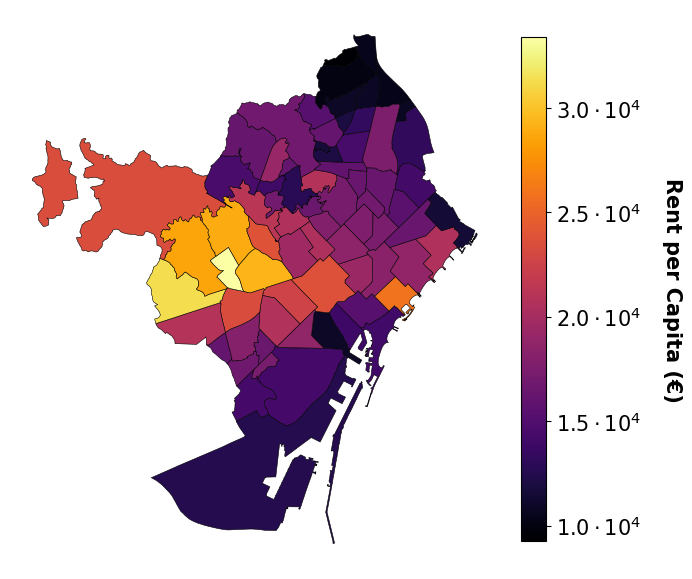

In [8]:
# --- CSV SELECTION ---

year = 2022

# --- LOAD DATA ---

df = prepare_gdf_rent(year)

# --- NORMALIZATION ---

vmin = df['rent_per_capita'].min()
vmax = df['rent_per_capita'].max()

# --- FIGURE ---

fig, ax = plt.subplots(1, 1, figsize = (7, 6))

mappable = plot_rent(year, ax)

# --- COLORBAR ---

cbar = plt.colorbar(mappable, ax = ax, label = 'Rent per Capita (€)', fraction = 0.047, pad = 0.04)

cbar.set_label('Rent per Capita (€)', fontsize = 15, fontweight = 'bold', labelpad = 30, rotation = 270)

# --- TICK FORMATTER ---

cbar.ax.yaxis.set_major_formatter(FuncFormatter(latex_sci_formatter))
cbar.ax.tick_params(labelsize = 15)

# ---------------------------------- SAVE FIGURE ----------------------------------

plt.tight_layout()

if save_figs:
    plt.savefig('./img/1_rent_per_capita_2022.png', dpi = 300, bbox_inches = 'tight') 

# ---------------------------------- SHOW FIGURE ----------------------------------

plt.show()


## 3.2 - Rent Map Time Evolution

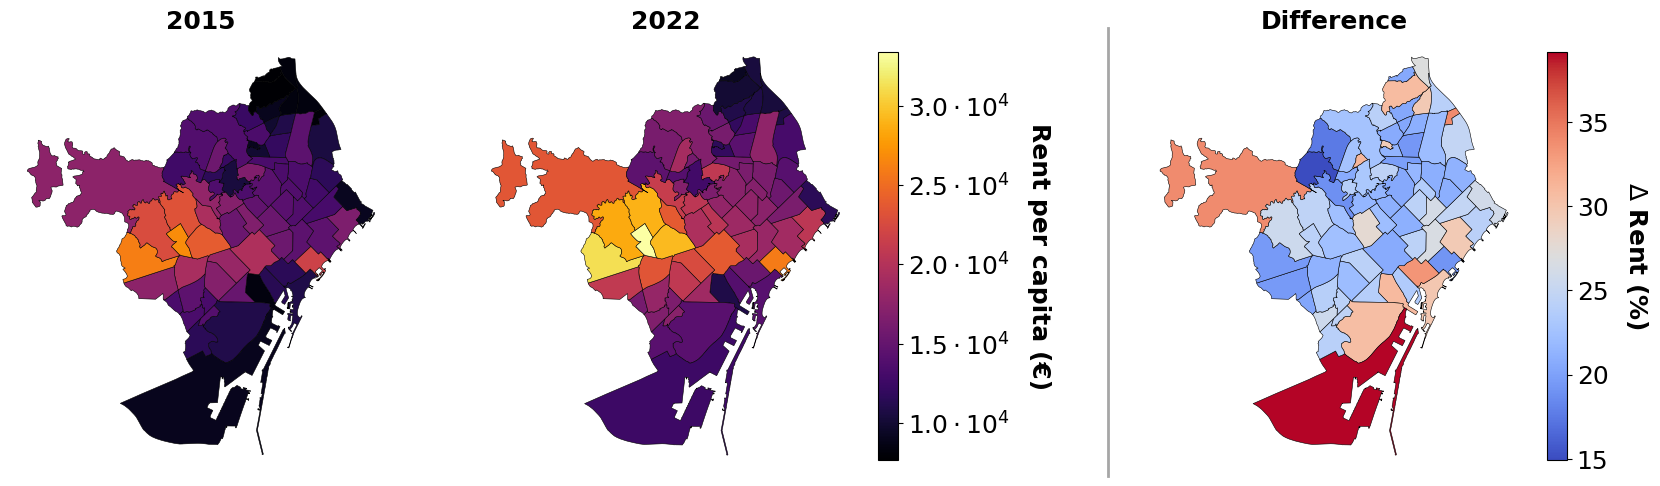

In [9]:
# --- GENERAL SCHEME ---

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (18, 8), gridspec_kw = {'width_ratios': [0.9, 1, 1]})

# ---------------------------------------- MAP FOR THE TWO SELECTED YEARS ----------------------------------------

# --- CSV SELECTION ---

initial_year = 2015
final_year = 2022

# --- LOAD DATA ---

gdf_rent_2015 = prepare_gdf_rent(initial_year)
gdf_rent_2022 = prepare_gdf_rent(final_year)

# --- NORMALIZATION --- (global)

vmin = min(gdf_rent_2015['rent_per_capita'].min(), gdf_rent_2022['rent_per_capita'].min())
vmax = max(gdf_rent_2015['rent_per_capita'].max(), gdf_rent_2022['rent_per_capita'].max())

# --- FIGURE ---

sm1 = plot_rent(initial_year, ax1)
sm2 = plot_rent(final_year, ax2)
ax1.set_title(str(initial_year), fontsize = 18, weight = 'bold')
ax2.set_title(str(final_year), fontsize = 18, weight = 'bold')

# --- COLORBARS ---

cbar2 = fig.colorbar(sm2, ax = ax2, fraction = 0.048, pad = 0.05)
cbar2.set_label('Rent per capita (€)', fontsize = 18, weight = 'bold', labelpad = 30, rotation = 270)
cbar2.ax.tick_params(labelsize = 18)

# --- TICK FORMATTER ---

cbar2.ax.yaxis.set_major_formatter(FuncFormatter(latex_sci_formatter))
cbar2.ax.tick_params(labelsize = 18)

# ---------------------------------------- MAP OF THE DIFFERENCE ---------------------------------------- 

# --- FIGURE ---

sm3 = plot_difference_rent(ax3, initial_year, final_year)
ax3.set_title('Difference', fontsize = 18, weight = 'bold')

# --- COLORBAR ---

cbar3 = fig.colorbar(sm3, ax = ax3, fraction = 0.048, pad = 0.05)
cbar3.set_label(r'$\Delta$ Rent (%)', fontsize = 18, weight = 'bold', labelpad = 30, rotation = 270)
cbar3.ax.tick_params(labelsize = 18)

# ---------------------------------------- COMPLEMENTARY ELEMENTS AND TWEAKS ---------------------------------------- 

# --- VERTICAL GREY DIVIDER ---

fig.add_artist(
    plt.Line2D(
        [0.735, 0.735],   # x-coordinates (fraction of figure width)
        [0.22, 0.78],     # y-coordinates (fraction of figure height)
        color = 'grey',
        linewidth = 2,
        alpha = 0.7))


# --- SHIFT SUBPLOT 3 --- (to make room for the divider)

shift = 0.09   

pos3 = ax3.get_position()
ax3.set_position([
    pos3.x0 + shift,
    pos3.y0,
    pos3.width,
    pos3.height])

cbar_pos3 = cbar3.ax.get_position()
cbar3.ax.set_position([
    cbar_pos3.x0 + shift,
    cbar_pos3.y0,
    cbar_pos3.width,
    cbar_pos3.height])

# ---------------------------------- SAVE FIGURE ----------------------------------

if save_figs:
    plt.savefig('./img/1_rent_evolution.png', dpi = 300, bbox_inches = 'tight') 

# ---------------------------------- SHOW FIGURE ----------------------------------

plt.show()


---
---

<div align='center' style='font-size: 30px;'>
STUDY OF THE POPULATION 
</div>

---

# 1 - Data Lecture

In our main dataset (birthPlaceRegion_sex), the 'Birth_Place_Region' column contains the following birthplace regions:

<div style='display: flex; gap: 15px; flex-wrap: wrap;'>
<div style='flex: 1; min-width: 200px;'>

**Africa**
- Eastern Africa
- Middle Africa
- Northern Africa
- Southern Africa
- Western Africa

**America**
- Caribbean
- Central America
- Northern America
- South America

</div>
<div style='flex: 1; min-width: 200px;'>

**Asia**
- Central Asia
- Eastern Asia
- Southern Asia
- South-Eastern Asia
- Western Asia

**Europe**
- Eastern Europe
- Northern Europe
- Southern Europe
- Western Europe

</div>
<div style='flex: 1; min-width: 200px;'>

**Oceania**
- Australia and New Zealand
- Melanesia

**Others**
- Not available

</div>
</div>

Nevertheless, my team have decided to group them in the following way:

<div style='display: flex; gap: 20px; flex-wrap: wrap; justify-content: space-between;'>
<div style='flex: 1; min-width: 250px;'>

**Africa***
- Eastern Africa → Africa
- Middle Africa → Africa  
- Southern Africa → Africa
- Western Africa → Africa

**Western Asia and Northern Africa (WAs-NAf)**
- Northern Africa → WAs-NAf
- Western Asia → WAs-NAf

**Latin America**
- Caribbean → Latin America
- Central America → Latin America
- South America → Latin America

</div>
<div style='flex: 1; min-width: 250px;'>

**Europe**
- Eastern Europe → Europe
- Northern Europe → Europe
- Southern Europe → Europe
- Western Europe → Europe

**NA-AUS-NZ**
- Australia and New Zealand → NA-AUS-NZ
- Northern America → NA-AUS-NZ
- Melanesia → NA-AUS-NZ

</div>
<div style='flex: 1; min-width: 250px;'>

**Asia***
- Eastern Asia → Asia
- South-Eastern Asia → Asia
- Southern Asia → Asia
- Central Asia → Asia

</div>
</div>

Finally, it is very important to notice that the Spanish population is included in the 'Europe' group. However, since we are studying immigration in Cataluña, it is better to separate them from the rest of European, letting them to have their own category. We will be able to do that thanks to other dataset (birthPlace_spain_v_outside) in which the groups are the following:

<div style='display: flex; gap: 20px; flex-wrap: wrap; justify-content: space-between;'>
<div style='flex: 1; min-width: 250px;'>

**Spain**
- City of Barcelona → Spain
- Rest of Catalonia → Spain  
- Rest of Spain → Spain

</div>
<div style='flex: 1; min-width: 250px;'>

**Immigrant**
- Rest of European Union → Immigrant
- Rest of World → Immigrant

</div>
</div>

Thus, we can distinguish between Spanish population and immigrants.

## 1.1 - Lecture including Spain as a separate category

In [10]:
def lecture_df(year, add_spain, level = 'Neighborhood'): # it returns a DataFrame with the number of people per grouped region

    # ---------------------------------------------------------------------------------------------------------------------------

    # --- LOAD DATA --- (Birth Place DataFrame)

    data_dir = '../data/birthPlaceRegion/'
    file = f'{year}_birthPlaceRegion_sex.csv'
    df = pd.read_csv(data_dir + file)

    # --- DATA CLEANING ---
    
    df['Value'] = pd.to_numeric(df['Value'], errors = 'coerce').fillna(0).astype(int) # convert to numeric, coerce errors to NaN, fill NaN with 0, convert to int
    df['Birth_Place_Region'] = df['Birth_Place_Region'].astype(str).str.strip() # ensure Birth_Place_Region is string and strip whitespace 

    #  --- IGNORE SEX ---

    df = df.groupby([level, 'Birth_Place_Region'], as_index = False)['Value'].sum()

    # --- GROUPING REGIONS ---

    region_map = {
        'Eastern Africa': 'Africa',
        'Middle Africa': 'Africa',
        'Southern Africa': 'Africa',
        'Western Africa': 'Africa',

        'Caribbean': 'Latin America',
        'Central America': 'Latin America',
        'South America': 'Latin America',

        'Northern Africa': 'WAs-NAf',
        'Western Asia': 'WAs-NAf',

        'Eastern Europe': 'Europe',
        'Northern Europe': 'Europe',
        'Southern Europe': 'Europe',
        'Western Europe': 'Europe',

        'Australia and New Zealand': 'NA-AUS-NZ',
        'Northern America': 'NA-AUS-NZ',
        'Melanesia': 'NA-AUS-NZ',

        'Eastern Asia': 'Asia',
        'South-Eastern Asia': 'Asia',
        'Central Asia': 'Asia',
        'Southern Asia': 'Asia'    
    }

    df['Group'] = df['Birth_Place_Region'].map(region_map).fillna('Other') # map regions to groups, fill unmapped with 'Other' (new column)

    # ---------------------------------------------------------------------------------------------------------------------------

    # --- LOAD DATA --- (Spanish vs Immigrant DataFrame)

    data_dir2 = '../data/birthPlace_spain_v_outside/'
    file2 = f'{year}_birthPlace_spain_v_outside.csv'
    df2 = pd.read_csv(data_dir2 + file2)

    # --- DATA CLEANING ---

    df2['Value'] = pd.to_numeric(df2['Value'], errors = 'coerce').fillna(0).astype(int) # convert to numeric, coerce errors to NaN, fill NaN with 0, convert to int
    df2['Birth_Place'] = df2['Birth_Place'].astype(str).str.strip() # ensure Birth_Place is string, strip whitespace

    # --- IGNORE SEX ---

    df2 = df2.groupby([level, 'Birth_Place'], as_index = False)['Value'].sum()

    # --- GROUPING REGIONS ---

    spanish_map = {
        'City of Barcelona': 'Spain',
        'Rest of Catalonia': 'Spain',
        'Rest of Spain': 'Spain',

        'Rest of European Union': 'Immigrant',
        'Rest of World': 'Immigrant',
    }

    df2['Group'] = df2['Birth_Place'].map(spanish_map).fillna('Other') # map birth places to groups, fill unmapped with 'Other' (new column)

    # ---------------------------------------------------------------------------------------------------------------------------

    # --- SUBTRACT SPANISH FROM ORIGINAL DATAFRAME  --- (particularly, European Group)

    ## Total Spanish population per neighborhood

    spanish_df = df2[df2['Group'] == 'Spain'].groupby(level)['Value'].sum().reset_index() # get total Spanish counts per neighborhood
    spanish_df.rename(columns = {'Value': 'Spain_Value'}, inplace = True) # rename for clarity and ease to subtract

    ## Merge Spanish counts into df

    df = df.merge(spanish_df, on = level, how = 'left') 
    df['Spain_Value'] = df['Spain_Value'].fillna(0) # fill NaN with 0 

    # Subtract Spanish from Europe group

    mask_europe = df['Group'] == 'Europe' 
    df.loc[mask_europe, 'Value'] = df.loc[mask_europe, 'Value'] - df.loc[mask_europe, 'Spain_Value'] 

    # Avoid negative values due to imperfect grouping

    df['Value'] = df['Value'].clip(lower = 0) # just in case

    # --- ADD SPAIN AS A GROUP --- (CONDITIONAL)

    if add_spain:  
        spain_group = spanish_df.copy()
        spain_group['Group'] = 'Spain'
        spain_group.rename(columns = {'Spain_Value': 'Value'}, inplace = True)

        df = pd.concat([df[[level, 'Group', 'Value']], spain_group[[level, 'Group', 'Value']]], ignore_index = True)

    # ---------------------------------------------------------------------------------------------------------------------------
    
    absolute_groups = df.groupby([level, 'Group'], as_index = False)['Value'].sum() # final grouping

    return absolute_groups



In [11]:
def dictionary_df(year, add_spain, level = 'Neighborhood'): # same as above but in dictionary format with year and add_spain as input

    # --- LOAD AND GROUP DATA ---

    df = lecture_df(year, add_spain, level = level)
    
    # --- DATA CLEANING ---

    df[level] = df[level].astype(str).str.strip() # ensure level column is string and strip whitespace
    df['Group'] = df['Group'].astype(str).str.strip() # ensure Group column is string and strip whitespace
    df['Value'] = pd.to_numeric(df['Value'], errors = 'coerce').fillna(0).astype(int) # convert Value to numeric, coerce errors to NaN, fill NaN with 0, convert to int

    # --- CREATE DICTIONARY ---

    neighborhood_dict = {}
    for neighborhood in df[level].unique():
        sub_df = df[df[level] == neighborhood].drop(columns = [level])
        neighborhood_dict[neighborhood] = sub_df.reset_index(drop = True)

    return neighborhood_dict

In [12]:
# # Test

# year = 2022
# add_spain = True

# data = lecture_df(year, add_spain)
# display(data)

---

# 2 - Diversity Calculation

## 2.1 - QUESTION: Can we measure the diversity of each neighborhood in Barcelona?

## 2.2 -PROCEDURE:

### 2.2.1 - Simpson's Diversity Index (D) and Dataframe Creation

We are going to use the Simpson's Index ($D$) to calculate the diversity of nationalities (birth place region) in EACH NEIGHBORHOOD, which is defined as:

$$ D = \sum_{i=1}^{S} \left( \frac{n_i}{N} \right)^2 $$

Where:

- $ S $ is the total number of different nationalities
- $ n_i $ is the number of individuals of nationality $ i $
- $ N $ is the total number of individuals

Then, we can compute the Simpson's Diversity Index ($D$) for each neighborhood as follows:

$$ \text{SDI} = 1 - \sum_{i=1}^{S} \left( \frac{n_i}{N} \right)^2 $$

It is important to notice that the value of SDI ranges from 0 to almost 1 (assymptotically), where a value close to 0 indicates low diversity (dominance of one nationality) and a value close to 1 indicates high diversity (more even distribution among nationalities).

Thus, we are taking an ecological approach to measure diversity since this index is widely used in ecology to quantify biodiversity in a community.

In [13]:
# Simpson's Diversity Index Calculation

def simpsons_diversity_index(df): # it returns the simpsons diversity index given a DataFrame

    N = df['Value'].sum()

    if N == 0:
        return 0  # avoid division by zero (just in case but not expected to happen)
    
    sum_pi_squared = sum((count / N) ** 2 for count in df['Value'])
    SDI = 1 - sum_pi_squared

    return SDI


Now, we need a function that, given a year, reads the corresponding data and calculates the diversity index for each neighborhood.

In [14]:
def compute_neighborhood_diversity(lecture_function, add_spain, year): # it returns a DataFrame with the diversity index per neighborhood given a year

    ## lecture_funtion should have a dictionary format with neighborhood as keys and DataFrames as values

    # --- LOAD DATA ---

    df_neighborhood = lecture_function(year, add_spain) 
    
    # --- COMPUTE SIMPSON'S DIVERSITY INDEX ---

    diversity_results = {} # initialize empty dictionary to store results

    for label_neighborhood, df in df_neighborhood.items(): # it  works over all the neighborhoods separately (different DataFrames)
        diversity_index = simpsons_diversity_index(df)
        diversity_results[label_neighborhood] = diversity_index
    
    # --- CONVERT TO DATAFRAME ---

    diversity_df = pd.DataFrame(list(diversity_results.items()), columns = ['Neighborhood', 'Simpsons_Diversity_Index'])
    
    # --- SORT DESCENDING --- (to better visualize the most and least diverse neighborhoods)

    diversity_df = diversity_df.sort_values(by = 'Simpsons_Diversity_Index', ascending = False).reset_index(drop = True)
    
    return diversity_df


In [15]:
# # Test

# lecture_function = dictionary_df
# add_spain = True
# year = 2022

# data = compute_neighborhood_diversity(lecture_function, add_spain, year)
# display(data)

### 2.2.2 - Visualization (color map)

In [16]:

def prepare_gdf(lecture_function, add_spain, year): # it returns a GeoDataFrame with the diversity index per neighborhood given a year

    # --- LOAD DATA ---

    df = compute_neighborhood_diversity(lecture_function, add_spain, year)  # columns: Neighborhood, Simpson_Diversity_Index

    # --------------------------------------------------------------------------------------------------------------------------------

    # --- GEOMETRY LOADING ---
    
    geometry_file = '../data/geometry/neighborhoods_geometry.csv'
    geometry_df = pd.read_csv(geometry_file)

    # --- CONVERT WKT STRINGS TO GEOMETRIES ---

    geometry_df['Geometry_etrs89'] = geometry_df['Geometry_etrs89'].apply(wkt.loads)

    # --- DATA CLEANING ---

    geometry_df['Neighborhood'] = geometry_df['Neighborhood'].astype(str).str.strip() # ensure Neighborhood is string and strip whitespace
    geometry_df['Neighborhood'] = geometry_df['Neighborhood'].apply(lambda x: unicodedata.normalize('NFC', x)) # normalize unicode

    # --- CREATE GEODATAFRAME ---

    gdf = gpd.GeoDataFrame(geometry_df, geometry = 'Geometry_etrs89', crs = 'EPSG:25831')

    # --------------------------------------------------------------------------------------------------------------------------------

    # --- MERGE DATAFRAMES ---
    
    merged_gdf = gdf.merge(df, on = 'Neighborhood', how = 'left')
    
    # --- DATA CLEANING ---

    merged_gdf['Simpsons_Diversity_Index'] = merged_gdf['Simpsons_Diversity_Index'].fillna(0) # fill missing diversity values with 0

    return merged_gdf


def plot_simpsons_index(lecture_function, add_spain, year, ax): # it plots the diversity index per neighborhood given a year
    global vmin, vmax

    gdf = prepare_gdf(lecture_function, add_spain, year)

    # --- NORMALIZATION ---

    norm = Normalize(vmin = vmin, vmax = vmax)

    #  --- PLOTTING ---

    gdf.plot(column = 'Simpsons_Diversity_Index',
             ax = ax,
             cmap = 'cividis',
             norm = norm,
             linewidth = 0.4,
             edgecolor = 'black')

    ax.axis('off')

    # --- SCALAR MAPPABLE --- (for the colorbar)

    sm = ScalarMappable(cmap = 'cividis', norm = norm) 
    sm.set_array([])  

    return sm 


In [17]:
def difference_df12(df1, df2): # it returns the percentage difference between two DataFrames

    # --- MERGE DATAFRAMES --- 
    
    merged_df = df1.merge(df2, on = 'Neighborhood', suffixes = ('_df1', '_df2'))

    # --- PERCENTAGE DIFFERENCE CALCULATION ---

    merged_df['Percentage_Difference'] = ((merged_df['Simpsons_Diversity_Index_df2'] - merged_df['Simpsons_Diversity_Index_df1']) / 
                                          merged_df['Simpsons_Diversity_Index_df1'].replace(0, np.nan)) * 100

    # --- DATA CLEANING --- (avoid division by zero issues)

    merged_df['Percentage_Difference'] = merged_df['Percentage_Difference'].replace([np.inf, -np.inf], np.nan).fillna(0) # replace inf with NaN and fill NaN with 0

    return merged_df[['Neighborhood', 'Percentage_Difference']]


def prepare_gdf_difference_df12(df1, df2): # it returns a GeoDataFrame with the percentage difference between two DataFrames

    # --- LOAD DIFFERENCE DATA ---

    difference_df = difference_df12(df1, df2)

    # --- GEOMETRY LOADING ---
    
    geometry_file = '../data/geometry/neighborhoods_geometry.csv'
    geometry_df = pd.read_csv(geometry_file)

    # --- CONVERT WKT STRINGS TO GEOMETRIES ---

    geometry_df['Geometry_etrs89'] = geometry_df['Geometry_etrs89'].apply(wkt.loads) 

    # --- DATA CLEANING ---

    geometry_df['Neighborhood'] = geometry_df['Neighborhood'].astype(str).str.strip() # ensure Neighborhood is string and strip whitespace
    geometry_df['Neighborhood'] = geometry_df['Neighborhood'].apply(lambda x: unicodedata.normalize('NFC', x)) # normalize unicode

    # --- CREATE GEODATAFRAME ---

    gdf = gpd.GeoDataFrame(geometry_df, geometry = 'Geometry_etrs89', crs = 'EPSG:25831')

    # ----------------------------------------------------------------------------------------------------------------------

    # --- MERGE DATAFRAMES ---
    
    merged_gdf = gdf.merge(difference_df, on = 'Neighborhood', how = 'left')
    
    # --- DATA CLEANING ---

    merged_gdf['Percentage_Difference'] = merged_gdf['Percentage_Difference'].fillna(0) # fill missing values with 0

    return merged_gdf


def plot_difference_gdf12(ax, df1, df2, cmap='coolwarm', log_scale = False): # it plots the percentage difference between two DataFrames (LogScale optional)

    # --- LOAD DIFFERENCE DATA ---

    gdf_diff = prepare_gdf_difference_df12(df1, df2)
    
    # --- NORMALIZATION ---

    diff_vmin = gdf_diff['Percentage_Difference'].min()
    diff_vmax = gdf_diff['Percentage_Difference'].max()
    
    if log_scale:
        if diff_vmin <= 0: # Ensure positive values for LogNorm

            ## Shift all values to be positive if needed

            shift = abs(diff_vmin) + 0.001  # Add small epsilon
            gdf_diff['Percentage_Difference_shifted'] = gdf_diff['Percentage_Difference'] + shift
            column_to_plot = 'Percentage_Difference_shifted'
            diff_vmin = gdf_diff[column_to_plot].min()
            diff_vmax = gdf_diff[column_to_plot].max()

        else:
            column_to_plot = 'Percentage_Difference' 
            
        from matplotlib.colors import LogNorm
    
        norm = LogNorm(vmin = diff_vmin, vmax = diff_vmax)

    else:

        column_to_plot = 'Percentage_Difference'
        norm = Normalize(vmin = diff_vmin, vmax=diff_vmax)
    
    # --- MAP ---

    gdf_diff.plot(
        column = column_to_plot,  # Use shifted column if log scale
        ax = ax,
        cmap = cmap,
        norm = norm,
        linewidth = 0.4,
        edgecolor = 'black')
    
    ax.axis('off')
    
    # --- SCALAR MAPPABLE --- (for the colorbar)

    sm = ScalarMappable(cmap = cmap, norm = norm)
    sm.set_array([])
    
    return sm



In [18]:
# # Test

# lecture_function = dictionary_df
# add_spain = True
# year = 2022

# df_merged = prepare_gdf(lecture_function, add_spain, year)
# display(df_merged)

## 2.3 - RESULTS

Our intention is to create a plot with two maps side by side, one showing the diversity including Spain as a separate category and another one not inluding Spain at all. Thus, in the first map, we will study the global diversity of Barcelona neighborhoods, while in the second one, we will focus on the diversity among immigrants.

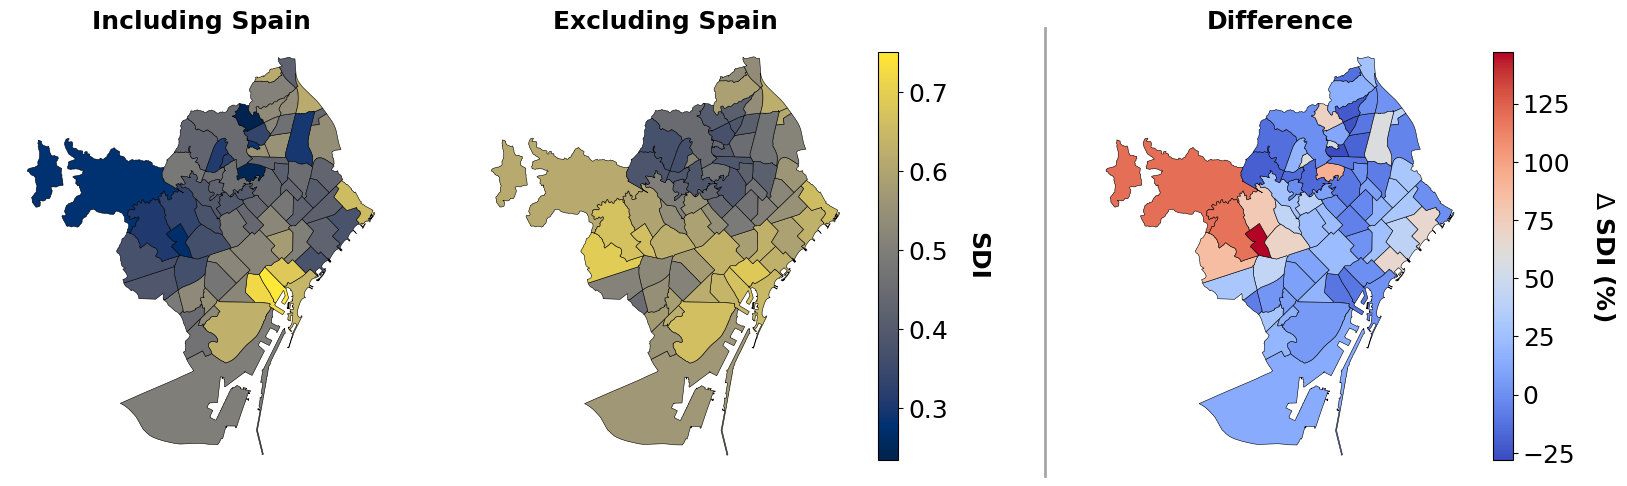

In [19]:
# --- GENERAL SCHEME ---

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (18, 8), gridspec_kw = {'width_ratios': [0.9, 1, 1]})

# ---------------------------------------- MAP FOR THE TWO SELECTED OPTIONS (WITH AND WITHOUT SPAIN) ----------------------------------------

# --- CSV SELECTION AND LOAD DATA FUNCTION ---

year = 2025
lecture_function = dictionary_df

# --- LOAD DATA ---

df_merged_spain = prepare_gdf(lecture_function, True, year)
df_merged_no_spain = prepare_gdf(lecture_function, False, year)

# --- NORMALIZATION --- (global)

vmin = min(df_merged_spain['Simpsons_Diversity_Index'].min(), df_merged_no_spain['Simpsons_Diversity_Index'].min())
vmax = max(df_merged_spain['Simpsons_Diversity_Index'].max(), df_merged_no_spain['Simpsons_Diversity_Index'].max())

# --- FIGURE ---

sm1 = plot_simpsons_index(lecture_function, True, year, ax1)
sm2 = plot_simpsons_index(lecture_function, False, year, ax2)
ax1.set_title('Including Spain', fontsize = 18, weight = 'bold')
ax2.set_title('Excluding Spain', fontsize = 18, weight = 'bold')

# --- COLORBARS ---

cbar2 = fig.colorbar(sm2, ax = ax2, fraction = 0.048, pad = 0.05)
cbar2.set_label('SDI', fontsize = 18, weight = 'bold', labelpad = 30, rotation = 270)
cbar2.ax.tick_params(labelsize = 18)

# ---------------------------------------- MAP OF THE DIFFERENCE ----------------------------------------

# --- FIGURE ---

sm3 = plot_difference_gdf12(ax3, df_merged_spain[['Neighborhood', 'Simpsons_Diversity_Index']], df_merged_no_spain[['Neighborhood', 'Simpsons_Diversity_Index']], 
                            log_scale = False)
ax3.set_title('Difference', fontsize = 18, weight = 'bold')

# --- COLORBAR ---

cbar3 = fig.colorbar(sm3, ax = ax3, fraction = 0.048, pad = 0.05)
cbar3.set_label(r'$\Delta$ SDI (%)', fontsize = 18, weight = 'bold', labelpad = 30, rotation = 270)
cbar3.ax.tick_params(labelsize = 18)

# ---------------------------------------- COMPLEMENTARY ELEMENTS AND TWEAKS ----------------------------------------

# --- VERTICAL GREY DIVIDER ---

fig.add_artist(
    plt.Line2D(
        [0.7, 0.7],   # x-coordinates (fraction of figure width)
        [0.22, 0.78],     # y-coordinates (fraction of figure height)
        color = 'grey',
        linewidth = 2,
        alpha = 0.7))


# --- SHIFT SUBPLOT 3 --- (to make room for the divider)

shift = 0.06   

pos3 = ax3.get_position()
ax3.set_position([
    pos3.x0 + shift,
    pos3.y0,
    pos3.width,
    pos3.height])

cbar_pos3 = cbar3.ax.get_position()
cbar3.ax.set_position([
    cbar_pos3.x0 + shift,
    cbar_pos3.y0,
    cbar_pos3.width,
    cbar_pos3.height])

# ---------------------------------- SAVE FIGURE ----------------------------------

if save_figs:
    plt.savefig('./img/2_simpsons_index_comparison.png', dpi = 300, bbox_inches = 'tight') 

# ---------------------------------- SHOW FIGURE ----------------------------------

plt.show()


## 2.4 - CONCLUSIONS

- Rich Neighborhoods

In neighborhoods like Sarrià-Sant Gervasi or Les Corts, which are mainly inhabited by Spanish people, the SDI increases when excluding Spanish population since we are working with a small fraction of the total population. Therefore, the few nationalities are more evenly distributed, leading to a higher diversity value.

- Poor Neighborhoods

On the other hand, in neighborhoods like Raval, El Poblenou or La Barceloneta, which are known for their high diversity, the SDI remains high in both cases, indicating that these neighboorhoods have a more even distribution of nationalities, even when including Spanish population. In fact, in some cases, the SDI is lower since the removal of Spanish population takes away a group that contributed to the overall diversity.


## 2.5 - EXTRA: time evolution of diversity in neighborhoods between 1997 and 2025

In [20]:
def df_difference(lecture_function, add_spain, initial_year, final_year): # it returns a GeoDataFrame with the difference in diversity index between two years (percentage)

    # --- LOAD INITIAL AND FINAL DATA ---

    df_initial = prepare_gdf(lecture_function, add_spain, initial_year)[['Neighborhood', 'Simpsons_Diversity_Index']]
    df_final = prepare_gdf(lecture_function, add_spain, final_year)[['Neighborhood', 'Simpsons_Diversity_Index']]

    # --- COMPUTE DIFFERENCE --- (in Simpson's Diversity Index)

    df_diff = df_final.copy()
    df_diff['Diversity_difference'] = (df_final['Simpsons_Diversity_Index'] - df_initial['Simpsons_Diversity_Index']) / df_initial['Simpsons_Diversity_Index'] * 100

    # --- DATA CLEANING ---

    df_diff['Diversity_difference'] = df_diff['Diversity_difference'].fillna(0)  # fill NaN values resulting from division by zero with 0

    # --- DATA SELECTION ---

    df_diff = df_diff[['Neighborhood', 'Diversity_difference']]

    # ----------------------------------------------------------------------------------------------------------------------

    # --- GEOMETRY LOADING ---

    geometry_file = '../data/geometry/neighborhoods_geometry.csv'
    geometry_df = pd.read_csv(geometry_file)

    # --- CONVERT WKT STRINGS TO GEOMETRIES ---

    geometry_df['Geometry_etrs89'] = geometry_df['Geometry_etrs89'].apply(wkt.loads)

    # --- DATA CLEANING ---

    geometry_df['Neighborhood'] = geometry_df['Neighborhood'].str.strip() # ensure Neighborhood is string and strip whitespace
    geometry_df['Neighborhood'] = geometry_df['Neighborhood'].apply(lambda x: unicodedata.normalize('NFC', x)) # normalize unicode

    # --- CREATE GEODATAFRAME ---

    gdf = gpd.GeoDataFrame(geometry_df, geometry = 'Geometry_etrs89', crs = 'EPSG:25831')

    # ----------------------------------------------------------------------------------------------------------------------

    # --- MERGE DATAFRAMES ---

    gdf_diff = pd.merge(gdf, df_diff, on = 'Neighborhood', how = 'left')

    return gdf_diff


def plot_difference(lecture_function, add_spain,ax, initial_year, final_year, cmap = 'coolwarm'):
    global diff_vmax, diff_vmin

    # --- LOAD DIFFERENCE DATA ---

    gdf_diff = df_difference(lecture_function, add_spain, initial_year, final_year)

    # --- NORMALIZATION ---
    
    norm = Normalize(vmin = diff_vmin, vmax = diff_vmax)

    # --- MAP ---
    gdf_diff.plot(
        column = 'Diversity_difference',
        ax = ax,
        cmap = cmap,
        norm = norm,
        linewidth = 0.4,
        edgecolor = 'black')

    ax.axis('off')
    
    # --- SCALAR MAPPABLE --- (for the colorbar)
    
    sm = ScalarMappable(cmap = cmap, norm = norm) 
    sm.set_array([])

    return sm



In [21]:
# # Test

# df_diff = df_difference(dictionary_df, True, 2015, 2025)

# display(df_diff)

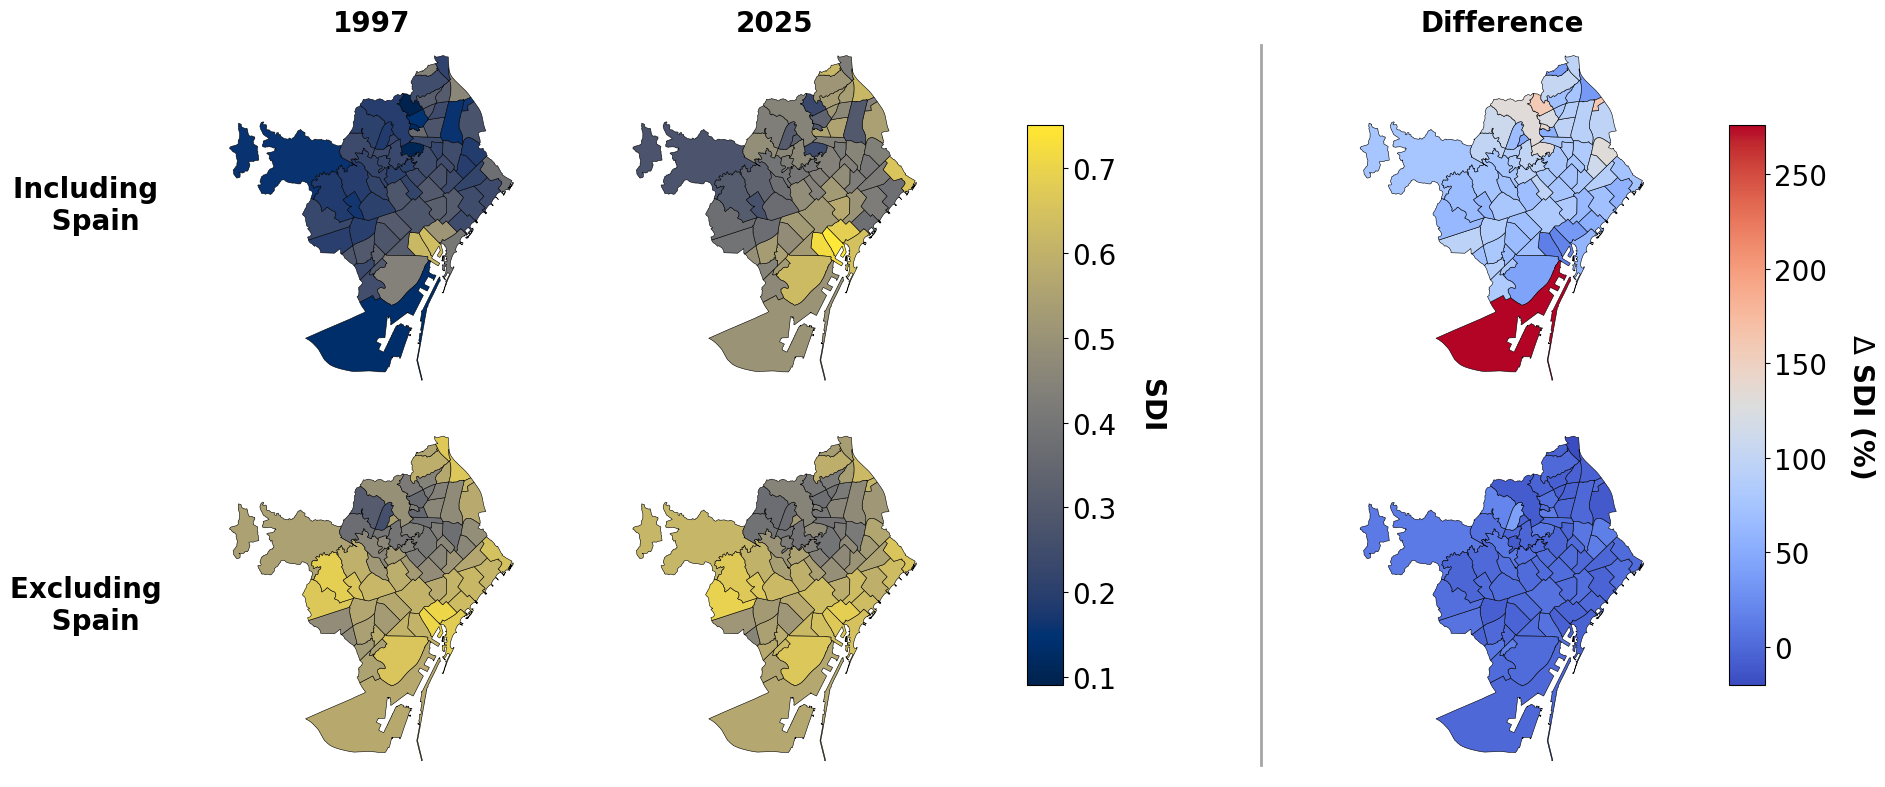

In [22]:
# --- CSVs SELECTION AND LOAD DATA FUNCTION ---

years = [1997, 2025]

lecture_function = dictionary_df

# --- LOAD DATA --- (dictionary format with year as key for each case)

df_years_spain = {year: prepare_gdf(lecture_function, True, year) for year in years}  
df_years_no_spain = {year: prepare_gdf(lecture_function, False, year) for year in years}  

df_diff_spain = df_difference(lecture_function, True, years[0], years[1])
df_diff_no_spain = df_difference(lecture_function, False, years[0], years[1])

# ---------------------------------------- NORMALIZATION ---------------------------------------- (global)

# --- DIVERSITY MAPS ---

vmin_spain = min(df_years_spain[year]['Simpsons_Diversity_Index'].min() for year in years)
vmax_spain = max(df_years_spain[year]['Simpsons_Diversity_Index'].max() for year in years)

vmin_no_spain = min(df_years_no_spain[year]['Simpsons_Diversity_Index'].min() for year in years)
vmax_no_spain = max(df_years_no_spain[year]['Simpsons_Diversity_Index'].max() for year in years)

vmin = min(vmin_spain, vmin_no_spain)
vmax = max(vmax_spain, vmax_no_spain)

# --- DIFFERENCE MAPS ---

diff_min_spain = df_diff_spain['Diversity_difference'].min()
diff_max_spain = df_diff_spain['Diversity_difference'].max()
diff_min_no_spain = df_diff_no_spain['Diversity_difference'].min()
diff_max_no_spain = df_diff_no_spain['Diversity_difference'].max()

diff_vmin = min(diff_min_spain, diff_min_no_spain)
diff_vmax = max(diff_max_spain, diff_max_no_spain)

# # ---------------------------------------- PLOTTING ----------------------------------------

# --- FIGURE --- (general scheme)

fig, axes = plt.subplots(2, 3, figsize = (18, 8), constrained_layout = True)
mappables = []

# --- ROW TITLES ---

fig.text(0.04, 0.75, 'Including \n Spain', fontsize = 20, weight = 'bold', ha = 'center', va = 'center', rotation = 0)
fig.text(0.04, 0.25, 'Excluding \n Spain', fontsize = 20, weight = 'bold', ha = 'center', va = 'center', rotation = 0)

# --- FIXED ORDERED LOOP --- (diversity maps)

for i, year in enumerate(years):
    # Row 0: Including Spain
    sm1 = plot_simpsons_index(lecture_function, True, year, axes[0, i])
    mappables.append(sm1)
    axes[0, i].set_title(f'{year}', fontsize = 20, weight = 'bold')
    
    # Row 1: Excluding Spain
    sm2 = plot_simpsons_index(lecture_function, False, year, axes[1, i])
    mappables.append(sm2)

# --- DIFFERENCE MAPS ---

sm_diff1 = plot_difference(lecture_function, True, axes[0, 2], years[0], years[1])
sm_diff2 = plot_difference(lecture_function, False, axes[1, 2], years[0], years[1])
axes[0, 2].set_title('Difference', fontsize = 20, weight = 'bold')

# ---------------------------------------- COLORBARS ----------------------------------------

# --- SHARED COLORBAR FOR DIVERSITY MAPS ---

cbar_ax1 = fig.add_axes([0.56, 0.15, 0.02, 0.7])  # [left, bottom, width, height]
cbar1 = fig.colorbar(sm1, cax = cbar_ax1)
cbar1.set_label('SDI', fontsize = 20, weight = 'bold', labelpad = 35, rotation = 270)
cbar1.ax.tick_params(labelsize = 20)

# --- SHARED COLORBAR FOR DIFFERENCE MAPS ---

cbar_ax2 = fig.add_axes([0.95, 0.15, 0.02, 0.7])  # [left, bottom, width, height]
cbar2 = fig.colorbar(sm_diff1, cax = cbar_ax2)
cbar2.set_label(r'$\Delta$ SDI (%)', fontsize = 20, weight = 'bold', labelpad = 35, rotation = 270)
cbar2.ax.tick_params(labelsize = 20)

# ---------------------------------------- COMPLEMENTARY ELEMENTS AND TWEAKS ----------------------------------------

# --- VERTICAL GREY DIVIDERS ---

fig.add_artist(
    plt.Line2D(
        [0.69, 0.69],   # x-coordinates (fraction of figure width)
        [0.05, 0.95],   # y-coordinates (fraction of figure height)
        color = 'grey',
        linewidth = 2,
        alpha = 0.7))


# --- ADJUSTMENTS --- (to make room for the divider)

shift = - 0.08   

for row in range(2):
    ax = axes[row, 1]      
    pos = ax.get_position()
    ax.set_position([pos.x0 + shift, pos.y0, pos.width, pos.height])

shift = 0.03   

for row in range(2):
    ax = axes[row, 0]      
    pos = ax.get_position()
    ax.set_position([pos.x0 + shift, pos.y0, pos.width, pos.height])

shift = -0.01 

for row in range(2):
    ax = axes[row, 2]      
    pos = ax.get_position()
    ax.set_position([pos.x0 + shift, pos.y0, pos.width, pos.height])

# --------------------------------------------- SAVE FIGURE ----------------------------------------------

if save_figs:
    plt.savefig('./img/2_simpsons_index_comparison_evolution.png', dpi = 300, bbox_inches = 'tight') 

# --------------------------------------------- SHOW FIGURE ----------------------------------------------

plt.show()



---

# 3 - Similarity Between Neighborhoods

## 3.1 - QUESTION: Giving some neighborhoods, how similar are them taking into account the share of nationalities (birth places) in each neighborhood?

Let's notice that with this method, there are several factors that can influence the results:

- Nationalities similarities
- Shares similarities (just by number -> social pattern organization) 
- We do not take into account the total population of each neighborhood in the measure of similarity

Therefore, the results should be interpreted with caution since they are not fully centered on cultural similarity.

## 3.2 - PROCEDURE:

We are going to use the cosine similarity method to calculate how similar the neighborhoods are. That means that we have to take into account the nationality distribution in each neighborhood.

In order to do that, we will create a vector for each neighborhood with the share of each nationality, and in the overall, a matrix where:

- Rows -> Neighborhoods
- Columns -> Nationalities
- Values -> Share of each nationality 


In [23]:
def nationality_proportion_matrix_all(lecture_function, add_spain, year): # it returns a DataFrame with the nationality proportions per neighborhood

    # --- LOAD DATA ---

    df = lecture_function(year, add_spain)

    # --- SORT NEIGHBORHOODS BY DIVERSITY ---

    diversity_df = compute_neighborhood_diversity(dictionary_df, add_spain, year) # already sorted descending
    sorted_neighborhoods = diversity_df['Neighborhood'].tolist()

    df['Neighborhood'] = pd.Categorical(df['Neighborhood'], categories = sorted_neighborhoods, ordered = True)

    # --- PIVOT TO MATRIX --- (to have neighborhoods as rows and groups as columns)

    matrix = df.pivot(index = 'Neighborhood', columns = 'Group', values = 'Value').fillna(0)

    # --- CONVERT TO PROPORTIONS --- (to have proportions instead of absolute counts)

    matrix = matrix.div(matrix.sum(axis=1), axis=0) # sum over rows and divide each element by the row sum

    return matrix

Once we have this matrix, we can calculate the cosine similarity between neighborhoods using the following formula:

$$ \text{cosine\_similarity}(\vec{A}, \vec{B}) = \frac{\vec{A} \cdot \vec{B}}{||\vec{A}|| \cdot ||\vec{B}||} $$

The main intention is to see if the order of the neighborhoods matters when visualizing the cosine similarity matrix as a heatmap (¿clusters?). Therefore, since our result will be sorted by SDI by default, we need a function that sorts the neighborhoods in a concrete order, for example, alphabetically. 

In [24]:
def sort_heatmap_alphabetically(heatmap_data): # it returns a DataFrame (matrix) sorted alphabetically by neighborhood names for heatmap plotting
    
    # --- GET NEIGHBORHOOD NAMES ---

    neighborhoods = heatmap_data.index.tolist()
    
    # --- SORT ALPHABETICALLY ---

    sorted_neighborhoods = sorted(neighborhoods)
    
    # --- REINDEX DATAFRAME ---
    
    sorted_data = heatmap_data.reindex(index = sorted_neighborhoods, columns = sorted_neighborhoods)
        
    return sorted_data

## 3.3 - RESULTS: 

In [25]:
# --- CSV SELECTION AND LOAD DATA FUNCTION ---

year = 2025
lecture_function = lecture_df

### 3.3.1 - Including Spain (global similarity)

In [26]:
add_spain = True

### Heatmap

In [27]:
# --- DIVERSITY DATAFRAME ---

df_diversity_spain  = compute_neighborhood_diversity(dictionary_df, add_spain, year)
sorted_neighborhoods = df_diversity_spain['Neighborhood']

# --- PROPORTION MATRIX ---

matrix_spain  = nationality_proportion_matrix_all(lecture_function, add_spain, year) # ordered by diversity index 

# --- COSINE SIMILARITY MATRIX ---

cos_sim = cosine_similarity(matrix_spain.values)

cos_sim_df_spain = pd.DataFrame(cos_sim, index = matrix_spain.index, columns = matrix_spain.index)

# --- SORT ALPHABETICALLY FOR HEATMAP ---

cos_sim_df_sorted = sort_heatmap_alphabetically(cos_sim_df_spain)


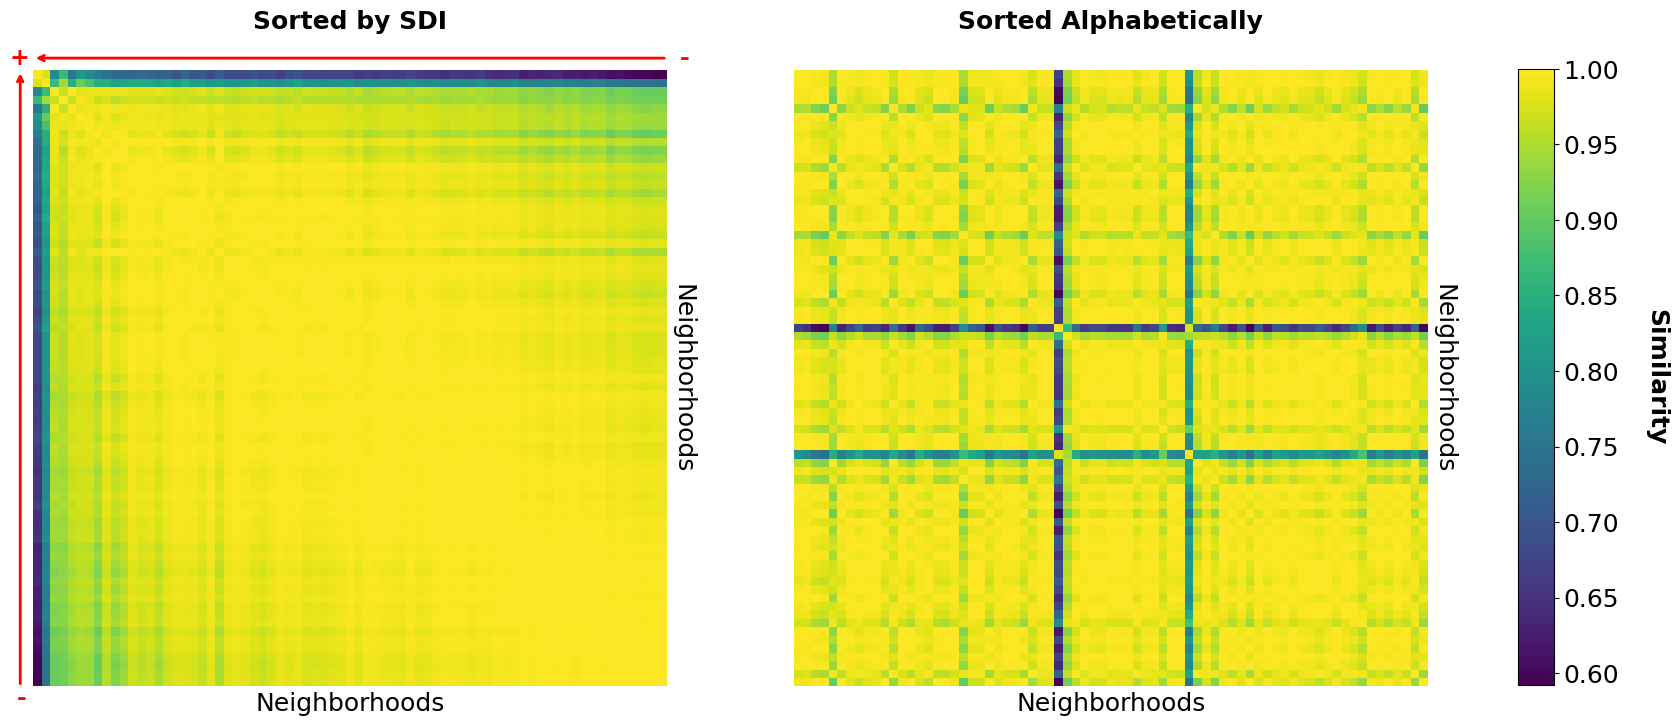

In [28]:
# --- FIGURE --- (general scheme)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (18, 8), sharey = True)
cmap = 'viridis'
df = cos_sim_df_spain
df_sorted = cos_sim_df_sorted

# --- NORMALIZATION --- (global for both heatmaps)

vmin = min(df.values.min(), df_sorted.values.min())
vmax = max(df.values.max(), df_sorted.values.max())

# ---------------------------------------- HEATMAPS ----------------------------------------

# --- LEFT SUBPLOT: SORTED BY SDI (NO COLORBAR)---

heatmap1 = sns.heatmap(df, 
            annot = False,
            cmap = cmap,
            cbar = False,  
            vmin = vmin, vmax = vmax,  
            xticklabels = False,
            yticklabels = False,
            ax = ax1)

# --- ADD ARROWS AND SIGNS ---

ax1.annotate('', xy = (-0.02, 1), xytext = (-0.02, 0.0),
            xycoords = 'axes fraction', textcoords = 'axes fraction',
            arrowprops = dict(arrowstyle = '->', color = 'red', lw = 2))
ax1.annotate('', xy = (0, 1.02), xytext = (1, 1.02),
            xycoords = 'axes fraction', textcoords = 'axes fraction',
            arrowprops = dict(arrowstyle = '->', color = 'red', lw = 2))

ax1.text(-0.005, 1.02, '+', fontsize = 17, weight = 'bold', color = 'red',
         ha = 'right', va = 'center', transform = ax1.transAxes)
ax1.text(1.02, 1.02, '-', fontsize = 17, weight = 'bold', color = 'red',
         ha = 'left', va = 'center', transform = ax1.transAxes)
ax1.text(-0.025, -0.02, '-', fontsize = 17, weight = 'bold', color = 'red',
         ha = 'left', va = 'center', transform = ax1.transAxes)

# --- GENERAL FEATURES ---

ax1.set_xlabel('Neighborhoods', fontsize = 18, alpha = 1)
ax1.yaxis.set_label_position("right")
ax1.set_ylabel('Neighborhoods', fontsize = 18, alpha = 1, rotation = 270, labelpad = 20)

ax1.set_title('Sorted by SDI', fontsize = 18, weight = 'bold', pad = 30)

# --- RIGHT SUBPLOT: SORTED ALPHABETICALLY (NO COLORBAR)---

heatmap2 = sns.heatmap(df_sorted, 
            annot = False,
            cmap = cmap,
            cbar = False,  
            vmin = vmin, vmax = vmax,  
            xticklabels = False,
            yticklabels = False,
            ax = ax2) 

# --- GENERAL FEATURES ---

ax2.set_xlabel('Neighborhoods', fontsize = 18, alpha = 1)
ax2.yaxis.set_label_position("right")
ax2.set_ylabel('Neighborhoods', fontsize = 18, alpha = 1, rotation = 270, labelpad = 20)

ax2.set_title('Sorted Alphabetically', fontsize = 18, weight = 'bold', pad = 30)

# ---------------------------------------- COLORBAR ---------------------------------------- (shared for both heatmaps)

# --- NORMALIZATION ---

cmap = plt.colormaps.get_cmap(cmap)
norm = plt.Normalize(vmin = vmin, vmax = vmax)

# --- ADD COLORBAR ---

cbar_ax = fig.add_axes([0.95, 0.112, 0.02, 0.77])  # [left, bottom, width, height]
sm = plt.cm.ScalarMappable(cmap = cmap, norm = norm)
sm.set_array([])

# --- COLORBAR LABEL ---

cbar = fig.colorbar(sm, cax = cbar_ax)
cbar.set_label('Similarity', fontsize = 18, weight = 'bold', labelpad = 35, rotation = 270)
cbar.ax.tick_params(labelsize = 18)

# ---------------------------------------- SAVE FIGURE ----------------------------------------

if save_figs:
    plt.savefig('./img/3_1_Spain_similarity_heatmaps.png', dpi = 300, bbox_inches = 'tight') 

# ---------------------------------------- SHOW FIGURE ----------------------------------------

plt.show()



We can observe that if we sort the neighborhoods by SDI, it seems to be two main clusters:

- Cluster 1: El Raval and Barri Gòtic (top left corner).
- Cluster 2: The rest of neighborhoods (bottom right corner).

However, if we sort them alphabetically, we can see that there is not a clear clustering pattern, indicating that it does exist some kind of relationship between diversity and social patterns organization.

### Eigenvalues Study

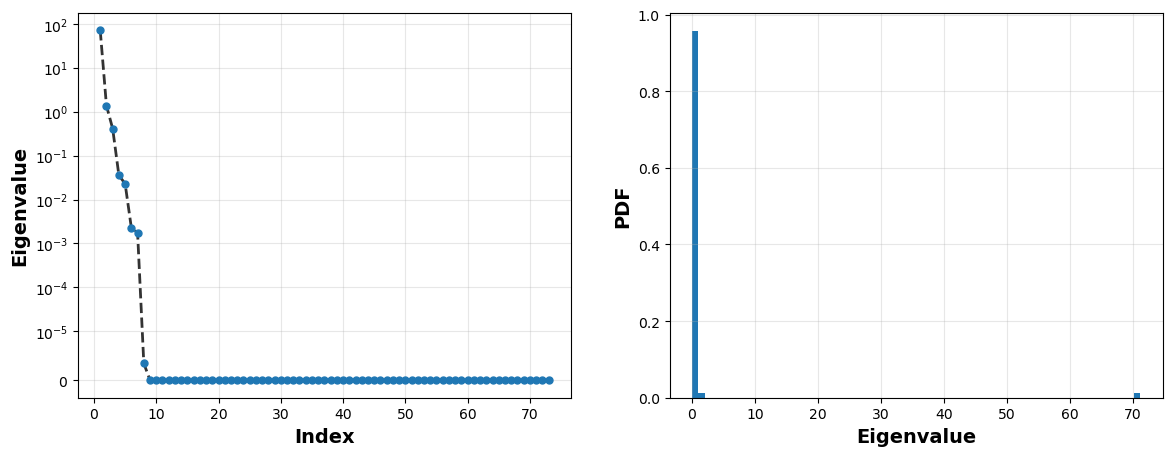

In [29]:
# --- EIGENVALUES CALCULATION ---

eigenvalues = np.linalg.eigvalsh(df)  
eigenvalues = np.sort(eigenvalues)[::-1]  # Sort descending

# --- FIGURE --- (general scheme)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (14, 5))

# --- EIGENVALUE SPECTRUM --- 

ax1.plot(range(1, len(eigenvalues)+1), eigenvalues, 'k--', linewidth = 2, alpha = 0.8)
ax1.plot(range(1, len(eigenvalues)+1), eigenvalues, 'o', markersize = 5)
ax1.set_xlabel('Index', fontsize = 14, weight = 'bold')
ax1.set_ylabel('Eigenvalue', fontsize = 14, weight = 'bold')
ax1.set_yscale('symlog', linthresh = 1e-5)
# ax1.set_title('Eigenvalue Spectrum', fontsize = 16, weight = 'bold')
ax1.grid(True, alpha = 0.3)

# --- PDF ---

ax2.hist(eigenvalues, bins = 70, density = True, alpha = 1)
ax2.set_xlabel('Eigenvalue', fontsize = 14, weight = 'bold')
ax2.set_ylabel('PDF', fontsize = 14, weight = 'bold')
# ax2.set_title('Eigenvalue Distribution (PDF)', fontsize = 16, weight = 'bold')
ax2.grid(True, alpha = 0.3)

# ---------------------------------------- SAVE FIGURE ----------------------------------------

if save_figs:
    plt.savefig('./img/3_1_Spain_similarity_eigenvalues.png', dpi = 300, bbox_inches = 'tight') 

# ---------------------------------------- SHOW FIGURE ----------------------------------------

plt.show()



We can observe that there is a eigenvalue significantly larger than the rest, which is the one that leads the social pattern behaviour in Barcelona neighborhoods. Combining this information with the heatmap, we can see that, in the overall, all neighborhoods are quite similar to each other (less 2 in the upper left corner), as we could have expected since they are all very diverse. We can try to get rid of the first eigenvalue to see if we can observe any hidden patterns. 

### Heatmap without the Highest Eigenvalue

In [30]:
# --- MATRIX WITHOUT THE HIGHEST EIGENVALUE COMPONENT ---

def remove_highest_eigen_component(cosine_sim_matrix): # it returns the cosine similarity matrix without the highest eigenvalue component

    # --- EIGENVALUE DECOMPOSITION ---

    eigenvalues, eigenvectors = np.linalg.eigh(cosine_sim_matrix)

    # --- IDENTIFY HIGHEST EIGENVALUE AND CORRESPONDING EIGENVECTOR ---

    max_index = np.argmax(eigenvalues)
    max_eigenvalue = eigenvalues[max_index]
    max_eigenvector = eigenvectors[:, max_index].reshape(-1, 1)  # Column vector

    # --- RECONSTRUCT HIGHEST EIGEN COMPONENT ---

    highest_component = max_eigenvalue * (max_eigenvector @ max_eigenvector.T)

    # --- SUBTRACT HIGHEST COMPONENT FROM ORIGINAL MATRIX ---

    modified_matrix = cosine_sim_matrix - highest_component

    return modified_matrix

# --- MODIFIED COSINE SIMILARITY MATRIX ---

modified_df = remove_highest_eigen_component(df.values)
modified_df = pd.DataFrame(modified_df, index = df.index, columns = df.columns)

# --- SORT ALPHABETICALLY FOR HEATMAP ---

modified_df_sorted = sort_heatmap_alphabetically(modified_df)

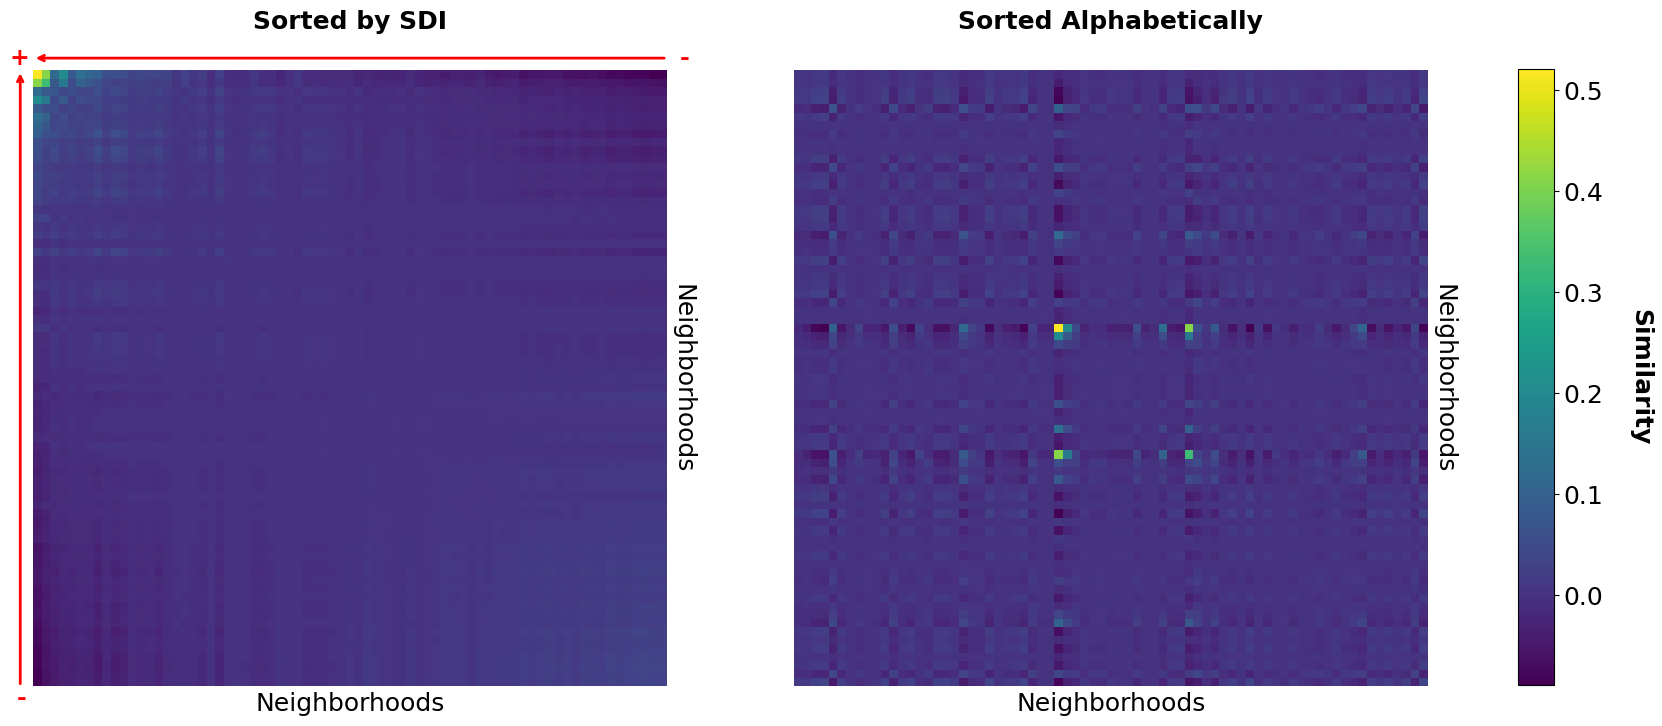

In [31]:
# --- FIGURE --- (general scheme)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (18, 8), sharey = True)
cmap = 'viridis'

# --- NORMALIZATION --- (global for both heatmaps)

vmin = min(modified_df.values.min(), modified_df_sorted.values.min())
vmax = max(modified_df.values.max(), modified_df_sorted.values.max())

# ---------------------------------------- HEATMAPS ----------------------------------------

# --- LEFT SUBPLOT: SORTED BY SDI (NO COLORBAR)---

heatmap1 = sns.heatmap(modified_df, 
            annot = False,
            cmap = cmap,
            cbar = False,  
            vmin = vmin, vmax = vmax,  
            xticklabels = False,
            yticklabels = False,
            ax = ax1)

# --- ADD ARROWS AND SIGNS ---

ax1.annotate('', xy = (-0.02, 1), xytext = (-0.02, 0.0),
            xycoords = 'axes fraction', textcoords = 'axes fraction',
            arrowprops = dict(arrowstyle = '->', color = 'red', lw = 2))
ax1.annotate('', xy = (0, 1.02), xytext = (1, 1.02),
            xycoords = 'axes fraction', textcoords = 'axes fraction',
            arrowprops = dict(arrowstyle = '->', color = 'red', lw = 2))

ax1.text(-0.005, 1.02, '+', fontsize = 17, weight = 'bold', color = 'red',
         ha = 'right', va = 'center', transform = ax1.transAxes)
ax1.text(1.02, 1.02, '-', fontsize = 17, weight = 'bold', color = 'red',
         ha = 'left', va = 'center', transform = ax1.transAxes)
ax1.text(-0.025, -0.02, '-', fontsize = 17, weight = 'bold', color = 'red',
         ha = 'left', va = 'center', transform = ax1.transAxes)

# --- GENERAL FEATURES ---

ax1.set_xlabel('Neighborhoods', fontsize = 18, alpha = 1)
ax1.yaxis.set_label_position("right")
ax1.set_ylabel('Neighborhoods', fontsize = 18, alpha = 1, rotation = 270, labelpad = 20)

ax1.set_title('Sorted by SDI', fontsize = 18, weight = 'bold', pad = 30)

# --- RIGHT SUBPLOT: SORTED ALPHABETICALLY (NO COLORBAR)---

heatmap2 = sns.heatmap(modified_df_sorted, 
            annot = False,
            cmap = cmap,
            cbar = False,  
            vmin = vmin, vmax = vmax,  
            xticklabels = False,
            yticklabels = False,
            ax = ax2) 

# --- GENERAL FEATURES ---

ax2.set_xlabel('Neighborhoods', fontsize = 18, alpha = 1)
ax2.yaxis.set_label_position("right")
ax2.set_ylabel('Neighborhoods', fontsize = 18, alpha = 1, rotation = 270, labelpad = 20)

ax2.set_title('Sorted Alphabetically', fontsize = 18, weight = 'bold', pad = 30)

# ---------------------------------------- COLORBAR ---------------------------------------- (shared for both heatmaps)

# --- NORMALIZATION ---

cmap = plt.colormaps.get_cmap(cmap)
norm = plt.Normalize(vmin = vmin, vmax = vmax)

# --- ADD COLORBAR ---

cbar_ax = fig.add_axes([0.95, 0.112, 0.02, 0.77])  # [left, bottom, width, height]
sm = plt.cm.ScalarMappable(cmap = cmap, norm = norm)
sm.set_array([])

# --- COLORBAR LABEL ---

cbar = fig.colorbar(sm, cax = cbar_ax)
cbar.set_label('Similarity', fontsize = 18, weight = 'bold', labelpad = 35, rotation = 270)
cbar.ax.tick_params(labelsize = 18)

# ---------------------------------------- SAVE FIGURE ----------------------------------------

if save_figs:
    plt.savefig('./img/3_1_Spain_similarity_heatmaps_mod.png', dpi = 300, bbox_inches = 'tight') 

# ---------------------------------------- COMPLEMENTARY ELEMENTS AND TWEAKS ----------------------------------------

plt.show()


### 3.3.2 - Excluding Spain (immigrant similarity)

In [32]:
add_spain = False

### Heatmap

In [33]:
# --- DIVERSITY DATAFRAME ---

df_diversity_no_spain  = compute_neighborhood_diversity(dictionary_df, add_spain, year)

# --- PROPORTION MATRIX ---

matrix_no_spain  = nationality_proportion_matrix_all(lecture_function, add_spain, year) # ordered by diversity index 

# --- COSINE SIMILARITY MATRIX ---

cos_sim = cosine_similarity(matrix_no_spain.values)

cos_sim_df_no_spain = pd.DataFrame(cos_sim, index = matrix_no_spain.index, columns = matrix_no_spain.index)

# --- SORT BY SDI --- (but using the order from the case with Spain to be able to compare both cases)

sorted_neighborhoods = df_diversity_spain['Neighborhood'].tolist()
cos_sim_df_no_spain_old = cos_sim_df_no_spain.reindex(index = sorted_neighborhoods, columns = sorted_neighborhoods)

# --- SORT ALPHABETICALLY FOR HEATMAP ---

cos_sim_df_sorted = sort_heatmap_alphabetically(cos_sim_df_no_spain)



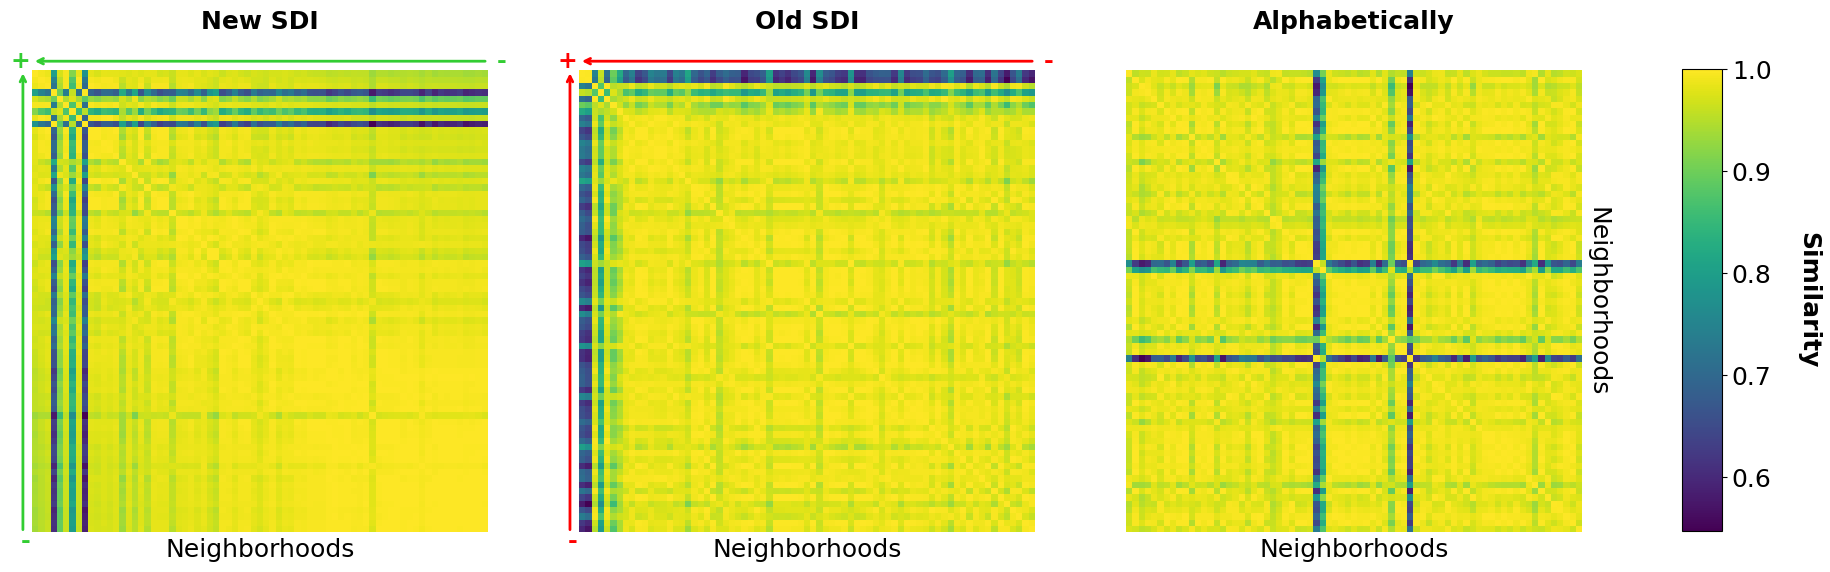

In [34]:
# --- FIGURE --- (general scheme)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (20, 6), sharey = True)
cmap = 'viridis'
df = cos_sim_df_no_spain
df_sorted_old = cos_sim_df_no_spain_old
df_sorted = cos_sim_df_sorted

# plt.suptitle('Sorted by ...', fontsize = 20, weight = 'bold', y = 1.07)

# --- NORMALIZATION --- (global for both heatmaps)

vmin = min(df.values.min(), df_sorted.values.min(), df_sorted_old.values.min())
vmax = max(df.values.max(), df_sorted.values.max(), df_sorted_old.values.max())

# ---------------------------------------- HEATMAPS ----------------------------------------

# --- LEFT SUBPLOT: SORTED BY SDI (NO COLORBAR)---

heatmap1 = sns.heatmap(df, 
            annot = False,
            cmap = cmap,
            cbar = False,  
            vmin = vmin, vmax = vmax,  
            xticklabels = False,
            yticklabels = False,
            ax = ax1)

# --- ADD ARROWS AND SIGNS ---

ax1.annotate('', xy = (-0.02, 1), xytext = (-0.02, 0.0),
            xycoords = 'axes fraction', textcoords = 'axes fraction',
            arrowprops = dict(arrowstyle = '->', color = 'limegreen', lw = 2))
ax1.annotate('', xy = (0, 1.02), xytext = (1, 1.02),
            xycoords = 'axes fraction', textcoords = 'axes fraction',
            arrowprops = dict(arrowstyle = '->', color = 'limegreen', lw = 2))

ax1.text(-0.005, 1.02, '+', fontsize = 17, weight = 'bold', color = 'limegreen',
         ha = 'right', va = 'center', transform = ax1.transAxes)
ax1.text(1.02, 1.02, '-', fontsize = 17, weight = 'bold', color = 'limegreen',
         ha = 'left', va = 'center', transform = ax1.transAxes)
ax1.text(-0.025, -0.02, '-', fontsize = 17, weight = 'bold', color = 'limegreen',
         ha = 'left', va = 'center', transform = ax1.transAxes)

# --- GENERAL FEATURES ---

ax1.set_xlabel('Neighborhoods', fontsize = 18, alpha = 1)
ax1.yaxis.set_label_position("right")
# ax1.set_ylabel('Neighborhoods', fontsize = 18, alpha = 1, rotation = 270, labelpad = 20)
ax1.set_ylabel('')
ax1.set_title('New SDI', fontsize = 18, weight = 'bold', pad = 30)

# --- MIDDLE SUBPLOT: SORTED BY OLD SDI --- (SPAIN CASE ORDER)

heatmap2 = sns.heatmap(df_sorted_old, 
            annot = False,
            cmap = cmap,
            cbar = False,  
            vmin = vmin, vmax = vmax,  
            xticklabels = False,
            yticklabels = False,
            ax = ax2) 

# --- ADD ARROWS AND SIGNS ---

ax2.annotate('', xy = (-0.02, 1), xytext = (-0.02, 0.0),
            xycoords = 'axes fraction', textcoords = 'axes fraction',
            arrowprops = dict(arrowstyle = '->', color = 'red', lw = 2))
ax2.annotate('', xy = (0, 1.02), xytext = (1, 1.02),
            xycoords = 'axes fraction', textcoords = 'axes fraction',
            arrowprops = dict(arrowstyle = '->', color = 'red', lw = 2))

ax2.text(-0.005, 1.02, '+', fontsize = 17, weight = 'bold', color = 'red',
         ha = 'right', va = 'center', transform = ax2.transAxes)
ax2.text(1.02, 1.02, '-', fontsize = 17, weight = 'bold', color = 'red',
         ha = 'left', va = 'center', transform = ax2.transAxes)
ax2.text(-0.025, -0.02, '-', fontsize = 17, weight = 'bold', color = 'red',
         ha = 'left', va = 'center', transform = ax2.transAxes)

# --- GENERAL FEATURES ---

ax2.set_xlabel('Neighborhoods', fontsize = 18, alpha = 1)
ax2.yaxis.set_label_position("right")
# ax2.set_ylabel('Neighborhoods', fontsize = 18, alpha = 1, rotation = 270, labelpad = 20)
ax2.set_ylabel('')

ax2.set_title('Old SDI', fontsize = 18, weight = 'bold', pad = 30)

# --- RIGHT SUBPLOT: SORTED ALPHABETICALLY (NO COLORBAR)---

heatmap3 = sns.heatmap(df_sorted, 
            annot = False,
            cmap = cmap,
            cbar = False,  
            vmin = vmin, vmax = vmax,  
            xticklabels = False,
            yticklabels = False,
            ax = ax3) 

# --- GENERAL FEATURES ---

ax3.set_xlabel('Neighborhoods', fontsize = 18, alpha = 1)
ax3.yaxis.set_label_position("right")
ax3.set_ylabel('Neighborhoods', fontsize = 18, alpha = 1, rotation = 270, labelpad = 20)

ax3.set_title('Alphabetically', fontsize = 18, weight = 'bold', pad = 30)

# ---------------------------------------- COLORBAR ---------------------------------------- (shared for both heatmaps)

# --- NORMALIZATION ---

cmap = plt.colormaps.get_cmap(cmap)
norm = plt.Normalize(vmin = vmin, vmax = vmax)

# --- ADD COLORBAR ---

cbar_ax = fig.add_axes([0.95, 0.112, 0.02, 0.77])  # [left, bottom, width, height]
sm = plt.cm.ScalarMappable(cmap = cmap, norm = norm)
sm.set_array([])

# --- COLORBAR LABEL ---

cbar = fig.colorbar(sm, cax = cbar_ax)
cbar.set_label('Similarity', fontsize = 18, weight = 'bold', labelpad = 35, rotation = 270)
cbar.ax.tick_params(labelsize = 18)

# ---------------------------------------- SAVE FIGURE ----------------------------------------

if save_figs:
    plt.savefig('./img/3_2_no_Spain_similarity_heatmaps.png', dpi = 300, bbox_inches = 'tight') 

# ---------------------------------------- SHOW FIGURE ----------------------------------------

plt.show()



### Eigenvalues Study

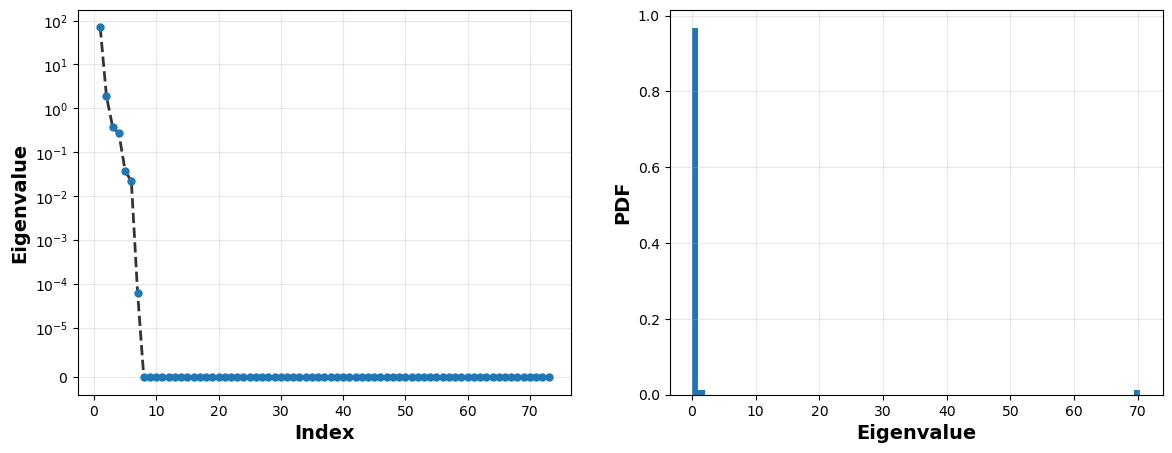

In [35]:
# --- EIGENVALUES CALCULATION ---

eigenvalues = np.linalg.eigvalsh(df)  
eigenvalues = np.sort(eigenvalues)[::-1]  # Sort descending

# --- FIGURE --- (general scheme)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (14, 5))

# --- EIGENVALUE SPECTRUM --- 

ax1.plot(range(1, len(eigenvalues)+1), eigenvalues, 'k--', linewidth = 2, alpha = 0.8)
ax1.plot(range(1, len(eigenvalues)+1), eigenvalues, 'o', markersize = 5)
ax1.set_xlabel('Index', fontsize = 14, weight = 'bold')
ax1.set_ylabel('Eigenvalue', fontsize = 14, weight = 'bold')
ax1.set_yscale('symlog', linthresh = 1e-5)
# ax1.set_title('Eigenvalue Spectrum', fontsize = 16, weight = 'bold')
ax1.grid(True, alpha = 0.3)

# --- PDF ---

ax2.hist(eigenvalues, bins = 70, density = True, alpha = 1)
ax2.set_xlabel('Eigenvalue', fontsize = 14, weight = 'bold')
ax2.set_ylabel('PDF', fontsize = 14, weight = 'bold')
# ax2.set_title('Eigenvalue Distribution (PDF)', fontsize = 16, weight = 'bold')
ax2.grid(True, alpha = 0.3)

# ---------------------------------------- SAVE FIGURE ----------------------------------------

if save_figs:
    plt.savefig('./img/3_2_no_Spain_similarity_eigenvalues.png', dpi = 300, bbox_inches = 'tight') 

# ---------------------------------------- SHOW FIGURE ----------------------------------------

plt.show()



### Heatmap without the Highest Eigenvalue

In [36]:
# --- MATRIX WITHOUT THE HIGHEST EIGENVALUE COMPONENT ---

def remove_highest_eigen_component(cosine_sim_matrix): # it returns the cosine similarity matrix without the highest eigenvalue component

    # --- EIGENVALUE DECOMPOSITION ---

    eigenvalues, eigenvectors = np.linalg.eigh(cosine_sim_matrix)

    # --- IDENTIFY HIGHEST EIGENVALUE AND CORRESPONDING EIGENVECTOR ---

    max_index = np.argmax(eigenvalues)
    max_eigenvalue = eigenvalues[max_index]
    max_eigenvector = eigenvectors[:, max_index].reshape(-1, 1)  # Column vector

    # --- RECONSTRUCT HIGHEST EIGEN COMPONENT ---

    highest_component = max_eigenvalue * (max_eigenvector @ max_eigenvector.T)

    # --- SUBTRACT HIGHEST COMPONENT FROM ORIGINAL MATRIX ---

    modified_matrix = cosine_sim_matrix - highest_component

    return modified_matrix

# --- MODIFIED COSINE SIMILARITY MATRIX ---

modified_df = remove_highest_eigen_component(df.values)
modified_df = pd.DataFrame(modified_df, index = df.index, columns = df.columns)

# --- SORT BY SDI --- (but using the order from the case with Spain to be able to compare both cases)

modified_df_old = modified_df.reindex(index = sorted_neighborhoods, columns = sorted_neighborhoods)

# --- SORT ALPHABETICALLY FOR HEATMAP ---

modified_df_sorted = sort_heatmap_alphabetically(modified_df)

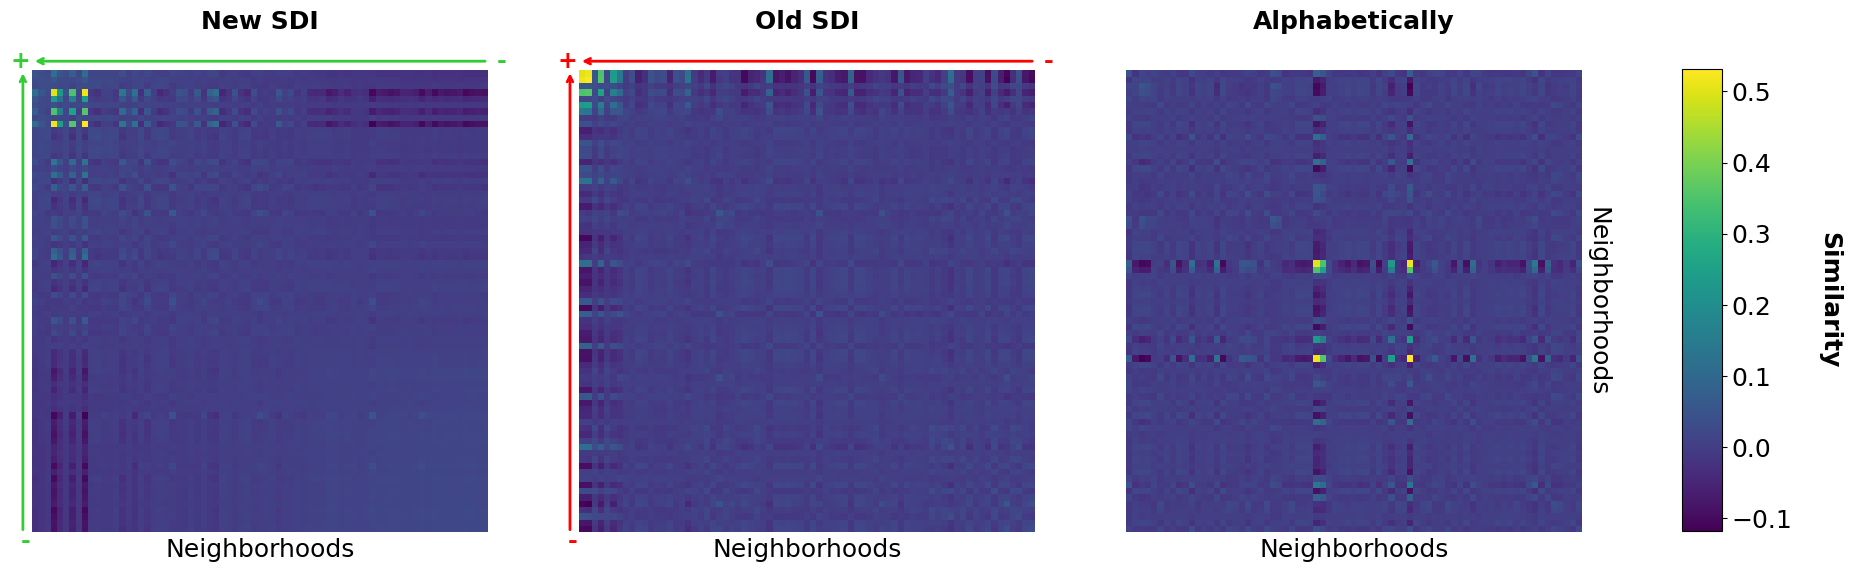

In [37]:
# --- FIGURE --- (general scheme)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (20, 6), sharey = True)
cmap = 'viridis'
df = modified_df
df_sorted_old = modified_df_old
df_sorted = modified_df_sorted

# plt.suptitle('Sorted by ...', fontsize = 20, weight = 'bold', y = 1.07)

# --- NORMALIZATION --- (global for both heatmaps)

vmin = min(df.values.min(), df_sorted.values.min(), df_sorted_old.values.min())
vmax = max(df.values.max(), df_sorted.values.max(), df_sorted_old.values.max())

# ---------------------------------------- HEATMAPS ----------------------------------------

# --- LEFT SUBPLOT: SORTED BY SDI (NO COLORBAR)---

heatmap1 = sns.heatmap(df, 
            annot = False,
            cmap = cmap,
            cbar = False,  
            vmin = vmin, vmax = vmax,  
            xticklabels = False,
            yticklabels = False,
            ax = ax1)

# --- ADD ARROWS AND SIGNS ---

ax1.annotate('', xy = (-0.02, 1), xytext = (-0.02, 0.0),
            xycoords = 'axes fraction', textcoords = 'axes fraction',
            arrowprops = dict(arrowstyle = '->', color = 'limegreen', lw = 2))
ax1.annotate('', xy = (0, 1.02), xytext = (1, 1.02),
            xycoords = 'axes fraction', textcoords = 'axes fraction',
            arrowprops = dict(arrowstyle = '->', color = 'limegreen', lw = 2))

ax1.text(-0.005, 1.02, '+', fontsize = 17, weight = 'bold', color = 'limegreen',
         ha = 'right', va = 'center', transform = ax1.transAxes)
ax1.text(1.02, 1.02, '-', fontsize = 17, weight = 'bold', color = 'limegreen',
         ha = 'left', va = 'center', transform = ax1.transAxes)
ax1.text(-0.025, -0.02, '-', fontsize = 17, weight = 'bold', color = 'limegreen',
         ha = 'left', va = 'center', transform = ax1.transAxes)

# --- GENERAL FEATURES ---

ax1.set_xlabel('Neighborhoods', fontsize = 18, alpha = 1)
ax1.yaxis.set_label_position("right")
# ax1.set_ylabel('Neighborhoods', fontsize = 18, alpha = 1, rotation = 270, labelpad = 20)
ax1.set_ylabel('')
ax1.set_title('New SDI', fontsize = 18, weight = 'bold', pad = 30)

# --- MIDDLE SUBPLOT: SORTED BY OLD SDI --- (SPAIN CASE ORDER)

heatmap2 = sns.heatmap(df_sorted_old, 
            annot = False,
            cmap = cmap,
            cbar = False,  
            vmin = vmin, vmax = vmax,  
            xticklabels = False,
            yticklabels = False,
            ax = ax2) 

# --- ADD ARROWS AND SIGNS ---

ax2.annotate('', xy = (-0.02, 1), xytext = (-0.02, 0.0),
            xycoords = 'axes fraction', textcoords = 'axes fraction',
            arrowprops = dict(arrowstyle = '->', color = 'red', lw = 2))
ax2.annotate('', xy = (0, 1.02), xytext = (1, 1.02),
            xycoords = 'axes fraction', textcoords = 'axes fraction',
            arrowprops = dict(arrowstyle = '->', color = 'red', lw = 2))

ax2.text(-0.005, 1.02, '+', fontsize = 17, weight = 'bold', color = 'red',
         ha = 'right', va = 'center', transform = ax2.transAxes)
ax2.text(1.02, 1.02, '-', fontsize = 17, weight = 'bold', color = 'red',
         ha = 'left', va = 'center', transform = ax2.transAxes)
ax2.text(-0.025, -0.02, '-', fontsize = 17, weight = 'bold', color = 'red',
         ha = 'left', va = 'center', transform = ax2.transAxes)

# --- GENERAL FEATURES ---

ax2.set_xlabel('Neighborhoods', fontsize = 18, alpha = 1) 
ax2.yaxis.set_label_position("right")
# ax2.set_ylabel('Neighborhoods', fontsize = 18, alpha = 1, rotation = 270, labelpad = 20)
ax2.set_ylabel('')

ax2.set_title('Old SDI', fontsize = 18, weight = 'bold', pad = 30)

# --- RIGHT SUBPLOT: SORTED ALPHABETICALLY (NO COLORBAR)---

heatmap3 = sns.heatmap(df_sorted, 
            annot = False,
            cmap = cmap,
            cbar = False,  
            vmin = vmin, vmax = vmax,  
            xticklabels = False,
            yticklabels = False,
            ax = ax3) 

# --- GENERAL FEATURES ---

ax3.set_xlabel('Neighborhoods', fontsize = 18, alpha = 1)
ax3.yaxis.set_label_position("right")
ax3.set_ylabel('Neighborhoods', fontsize = 18, alpha = 1, rotation = 270, labelpad = 20)

ax3.set_title('Alphabetically', fontsize = 18, weight = 'bold', pad = 30)

# ---------------------------------------- COLORBAR ---------------------------------------- (shared for both heatmaps)

# --- NORMALIZATION ---

cmap = plt.colormaps.get_cmap(cmap)
norm = plt.Normalize(vmin = vmin, vmax = vmax)

# --- ADD COLORBAR ---

cbar_ax = fig.add_axes([0.95, 0.112, 0.02, 0.77])  # [left, bottom, width, height]
sm = plt.cm.ScalarMappable(cmap = cmap, norm = norm)
sm.set_array([])

# --- COLORBAR LABEL ---

cbar = fig.colorbar(sm, cax = cbar_ax)
cbar.set_label('Similarity', fontsize = 18, weight = 'bold', labelpad = 35, rotation = 270)
cbar.ax.tick_params(labelsize = 18)

# ---------------------------------------- SAVE FIGURE ----------------------------------------

if save_figs:
    plt.savefig('./img/3_2_no_Spain_similarity_heatmaps_mod.png', dpi = 300, bbox_inches = 'tight') 

# ---------------------------------------- SHOW FIGURE ----------------------------------------

plt.show()


---
---

<div align='center' style='font-size: 30px;'>
RELATION BETWEEN RENT AND DIVERSITY
</div>

---

# 1 - QUESTION: Is there any relation between the rent of a neighborhood and its diversity?

# 2 - PROCEDURE:

We take the rent data and the diversity data from the previous studied datasets. Then, we create a scatter plot with the rent as x-axis and the diversity (SDI) as y-axis. Finally, we can try to do some kind of fitting to see if there is any correlation between both variables.

# 3 - RESULTS:

In [38]:
# ---------------------------------------- RENT PER CAPITA DATAFRAME ----------------------------------------

# --- LOAD DATA ---

gdf_rent = prepare_gdf_rent(2022)

# --- SELECT COLUMNS ---

df_rent = gdf_rent[['Neighborhood', 'rent_per_capita']]

# ---------------------------------------- DIVERSITY DATAFRAME ----------------------------------------

df_diversity = compute_neighborhood_diversity(dictionary_df, True, 2022)

## we choose add_spain = True since rent data includes Spanish Population

df_diversity['Neighborhood'] = df_diversity['Neighborhood'].str.strip().str.lower()

# ---------------------------------------- MERGE DATAFRAMES ----------------------------------------

merged_df = pd.merge(df_diversity, df_rent, on = 'Neighborhood', how = 'left')

display(merged_df)


,Neighborhood,Simpsons_Diversity_Index,rent_per_capita
0,el barri gòtic,0.746637,13971.0
1,el raval,0.697037,10893.0
2,"sant pere, santa caterina i la ribera",0.651655,15379.0
3,la barceloneta,0.596670,14117.0
4,el poble-sec,0.587651,14272.0
...,...,...,...
68,sant andreu,0.239423,17635.0
69,"vallvidrera, el tibidabo i les planes",0.221125,23458.0
70,les tres torres,0.218330,33382.0
71,la font d'en fargues,0.189590,20795.0


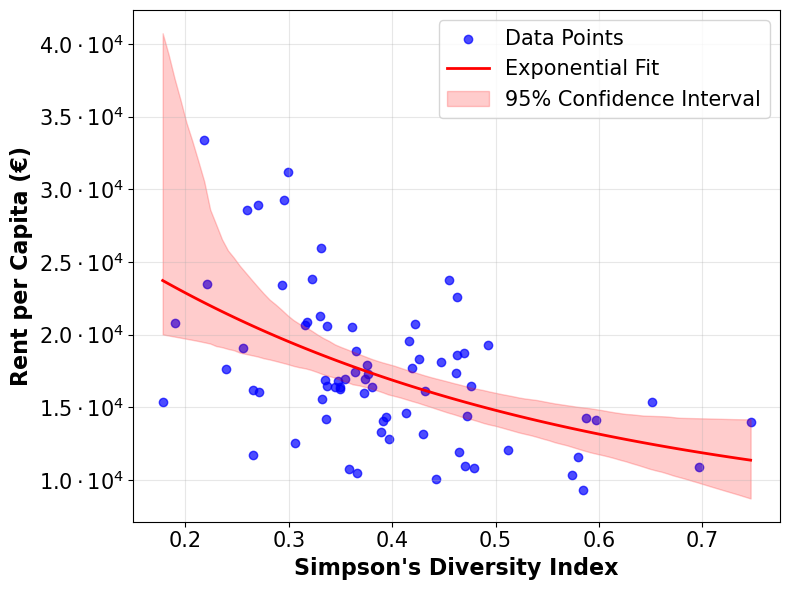

Exponential decay parameters:
a = 25462.69, b = 2.39, c = 7079.80


In [39]:
# --- LOAD DATA ---

x = merged_df['Simpsons_Diversity_Index']
y = merged_df['rent_per_capita']

# --------------------------------------------------- EXPONENTIAL DECAY FITTING WITH CONFIDENCE INTERVAL ---------------------------------------------------

# --- FIT MODEL ---

def exp_decay(x, a, b, c):
    return a * np.exp(-b * x) + c

# --- FIT ---

initial_guess = [max(y), 1, min(y)]
params, covariance = curve_fit(exp_decay, x, y, p0 = initial_guess, maxfev = 5000)

x_smooth = np.linspace(x.min(), x.max(), 100)
y_smooth = exp_decay(x_smooth, *params)

# --- CONFIDENCE INTERVAL ---

n_bootstraps = 500
bootstrap_preds = []

for _ in range(n_bootstraps):
    indices = np.random.choice(len(x), len(x), replace = True)
    x_boot = x.iloc[indices]
    y_boot = y.iloc[indices]
    
    params_boot, _ = curve_fit(exp_decay, x_boot, y_boot, p0 = params, maxfev = 5000)
    y_boot_pred = exp_decay(x_smooth, *params_boot)
    bootstrap_preds.append(y_boot_pred)

bootstrap_preds = np.array(bootstrap_preds)
lower_ci = np.percentile(bootstrap_preds, 2.5, axis = 0)
upper_ci = np.percentile(bootstrap_preds, 97.5, axis = 0)

# ------------------------------------------------ PLOTTING ----------------------------------------

# --- FIGURE ---

plt.figure(figsize = (8, 6))
plt.scatter(x, y, color = 'blue', alpha = 0.7, label = 'Data Points')
plt.plot(x_smooth, y_smooth, color = 'red', linewidth = 2, label = 'Exponential Fit')
plt.fill_between(x_smooth, lower_ci, upper_ci, color = 'red', alpha = 0.2, label = '95% Confidence Interval')

# --- LABELS ---

plt.ylabel('Rent per Capita (€)', fontsize = 16, weight = 'bold')
plt.xlabel("Simpson's Diversity Index", fontsize = 16, weight = 'bold')

# --- APPLY LATEX SCIENTIFIC NOTATION ---

plt.gca().yaxis.set_major_formatter(FuncFormatter(latex_sci_formatter))

# --- TWEAKS ---

plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.grid(True, alpha = 0.3)
plt.legend(fontsize = 15)
plt.tight_layout()

# ---------------------------------------- SAVE FIGURE ----------------------------------------

if save_figs:
    plt.savefig('./img/4_rent_diversity.png', dpi = 300, bbox_inches = 'tight') 

# ---------------------------------------- SHOW FIGURE ----------------------------------------


plt.show()

# --- PRINTS  ---

print("Exponential decay parameters:")
print(f"a = {params[0]:.2f}, b = {params[1]:.2f}, c = {params[2]:.2f}")
